<a href="https://colab.research.google.com/github/SarkarPriyanshu/Machine-Learning-Models/blob/main/Health_Insurance_Cross_Sell_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
!pip install feature-engine -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 KB 6.6 MB/s eta 0:00:00


## Libraries

In [102]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from feature_engine.discretisation import DecisionTreeDiscretiser

import warnings
warnings.filterwarnings('ignore')


## Data Gathering

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d anmolkumar/health-insurance-cross-sell-prediction

 62% 4.00M/6.47M [00:00<00:00, 6.00MB/s]
100% 6.47M/6.47M [00:01<00:00, 6.60MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/health-insurance-cross-sell-prediction.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
df =  pd.read_csv('/content/train.csv')

## Data Assesment

- `id`	Unique ID for the customer (Remove this columns)
- `Gender`	Gender of the customer (Categorical)
- `Age`	Age of the customer (Numeric)
- `Driving_License`	0 : Customer does not have DL, 1 : Customer already has DL (Categorical)
- `Region_Code`	Unique code for the region of the customer (Numeric)
- `Previously_Insured`	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance (Categorical)
-`Vehicle_Age`	Age of the Vehicle (Numeric)
-`Vehicle_Damage`	1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past. (Categorical)
-`Annual_Premium`	The amount customer needs to pay as premium in the year (Numeric)
-`Policy_Sales_Channel`	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
-`Vintage`	Number of Days, Customer has been associated with the company (Numeric)
-`Response`	1 : Customer is interested, 0 : Customer is not *interested* (Target)

#### Observation of Assesment
  - Imbalance dataset in terms of target feature, policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company `87.74%` response is `No` where only `12.25%` response is `Yes`.
  - No Null values to handle
  - Need to Drop Id feature from dataset
  - `Vehicle_Age` is a categorical feature that need to be preprocessed 


## Basic Analysis

In [ ]:
df.shape

(381109, 12)

In [ ]:
df.sample(25)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
45150,45151,Male,32,1,8.0,0,< 1 Year,No,2630.0,1.0,204,1
353002,353003,Male,27,1,28.0,1,< 1 Year,No,35743.0,152.0,248,0
56313,56314,Female,23,1,17.0,1,< 1 Year,No,59221.0,152.0,13,0
335309,335310,Female,56,1,31.0,1,1-2 Year,No,2630.0,124.0,41,0
228115,228116,Male,26,1,28.0,1,< 1 Year,No,45504.0,152.0,29,0
17573,17574,Male,54,1,28.0,0,1-2 Year,Yes,49998.0,26.0,213,0
70238,70239,Male,38,1,41.0,0,1-2 Year,Yes,32697.0,124.0,256,0
195955,195956,Female,23,1,16.0,1,< 1 Year,No,21056.0,151.0,187,0
284335,284336,Male,44,1,15.0,0,1-2 Year,Yes,26057.0,124.0,121,0
98551,98552,Female,44,1,45.0,0,> 2 Years,Yes,2630.0,26.0,272,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [ ]:
df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [ ]:
df.corr()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,1.000000,0.001561,-0.000564,-0.000572,0.002457,0.003027,-0.002837,-0.000630,-0.001368
Age,0.001561,1.000000,-0.079782,0.042574,-0.254682,0.067507,-0.577826,-0.001264,0.111147
Driving_License,-0.000564,-0.079782,1.000000,-0.001081,0.014969,-0.011906,0.043731,-0.000848,0.010155
Region_Code,-0.000572,0.042574,-0.001081,1.000000,-0.024659,-0.010588,-0.042420,-0.002750,0.010570
Previously_Insured,0.002457,-0.254682,0.014969,-0.024659,1.000000,0.004269,0.219381,0.002537,-0.341170
Annual_Premium,0.003027,0.067507,-0.011906,-0.010588,0.004269,1.000000,-0.113247,-0.000608,0.022575
Policy_Sales_Channel,-0.002837,-0.577826,0.043731,-0.042420,0.219381,-0.113247,1.000000,0.000002,-0.139042
Vintage,-0.000630,-0.001264,-0.000848,-0.002750,0.002537,-0.000608,0.000002,1.000000,-0.001050
Response,-0.001368,0.111147,0.010155,0.010570,-0.341170,0.022575,-0.139042,-0.001050,1.000000


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.skew()

id                      9.443274e-16
Age                     6.725390e-01
Driving_License        -2.159518e+01
Region_Code            -1.152664e-01
Previously_Insured      1.677471e-01
Annual_Premium          1.766087e+00
Policy_Sales_Channel   -9.000081e-01
Vintage                 3.029517e-03
Response                2.301906e+00
dtype: float64

#### Observation of Basic Analysis
  - `0 Null values` to handle
  - `Annual_Premium` having outliers
  - One hot encoding required in `Vehicle_Age`,`Gender` &	`Vehicle_Damage`.
  - `0 Duplicated rows` 
  - Skewed features need for `transformations` 	

## EDA

### Uni-variant Analysis

In [7]:
df.drop('id',axis=1,inplace=True)

In [8]:
target = 'Response'
numeric_features =  [feature for feature in df.columns if feature != target and (df[feature].dtype == 'int' or df[feature].dtype == 'float')]
categorical_features =  [feature for feature in df.columns  if feature != target and (df[feature].dtype != 'int' and df[feature].dtype != 'float')]

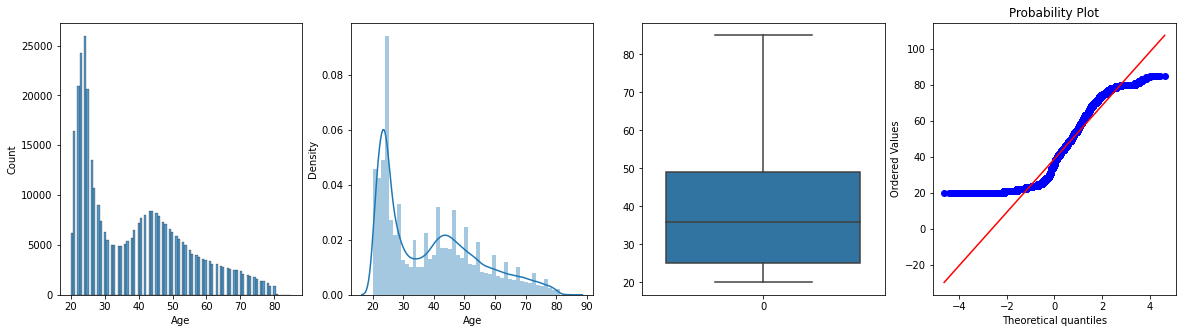

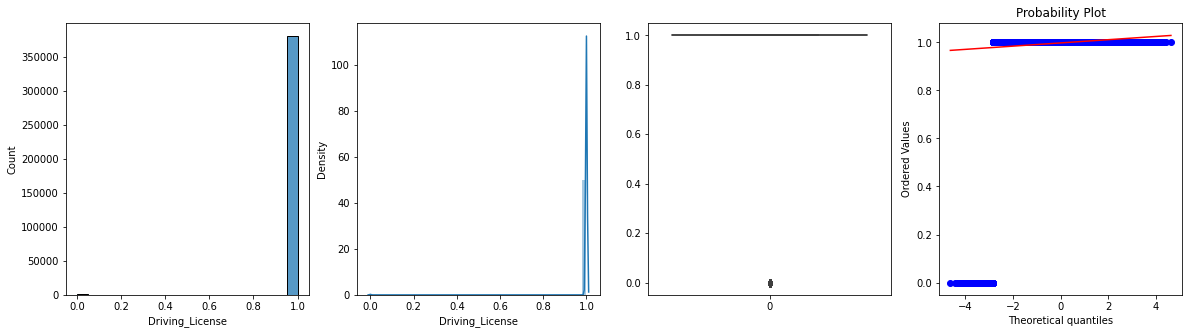

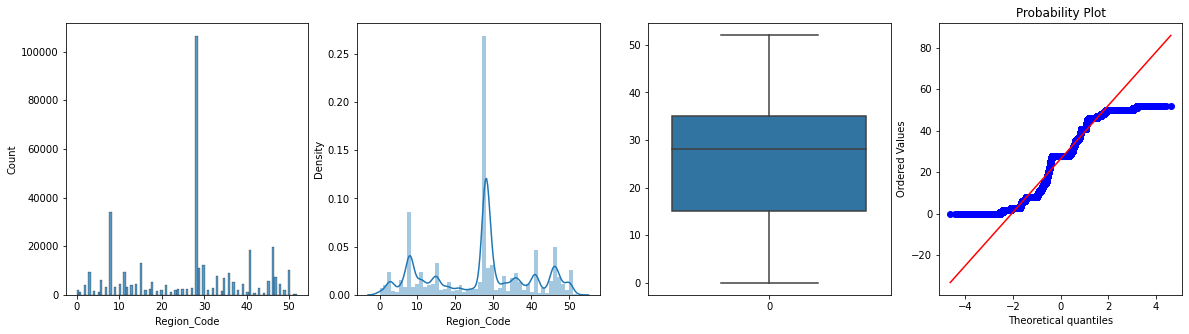

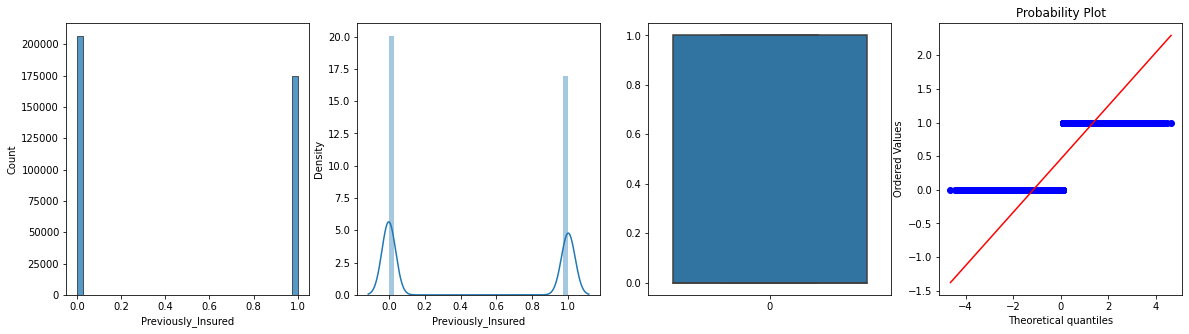

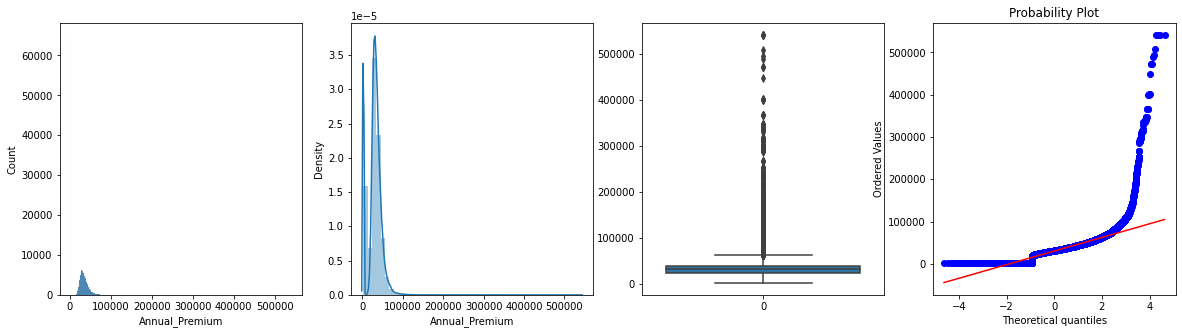

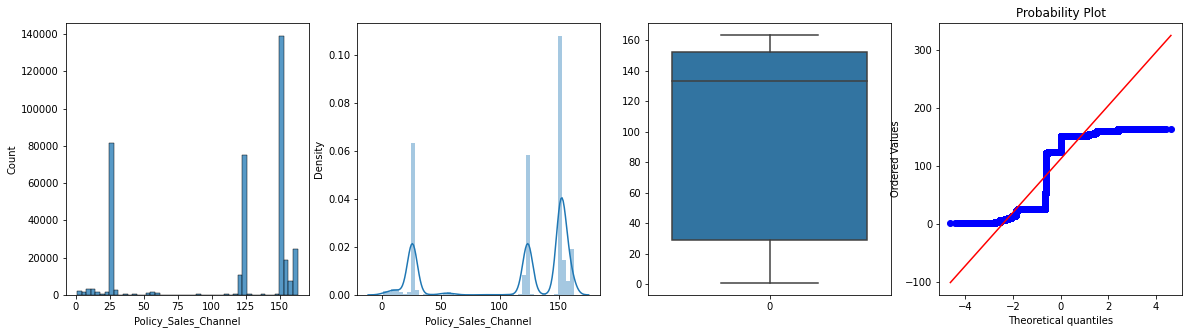

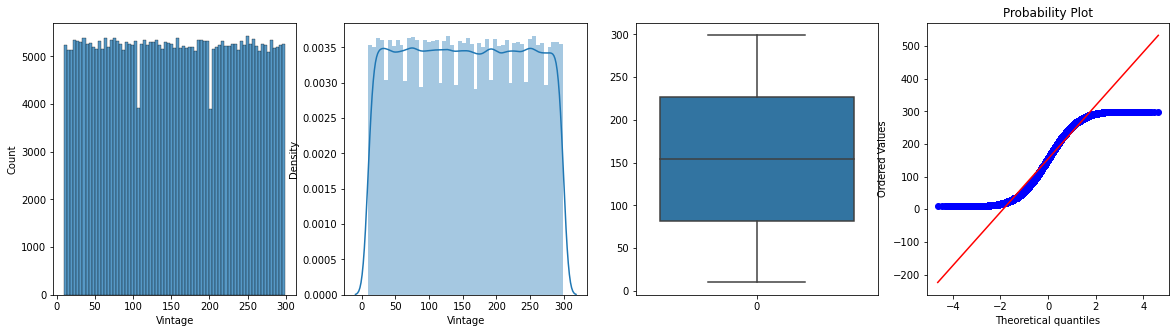

In [ ]:
for feature in numeric_features:
  fig, ax = plt.subplots(1,4,figsize=(20, 5))
  sns.histplot(df[feature], ax=ax[0])
  sns.distplot(df[feature], ax=ax[1])
  sns.boxplot(df[feature],ax=ax[2])
  stats.probplot(df[feature], plot=ax[3], fit=True)
  fig.show()

### Observation of univarient analysis for numeric features
  - `Outliers` in `Annual_Premium` feature
  - `Skewed` distribution of features

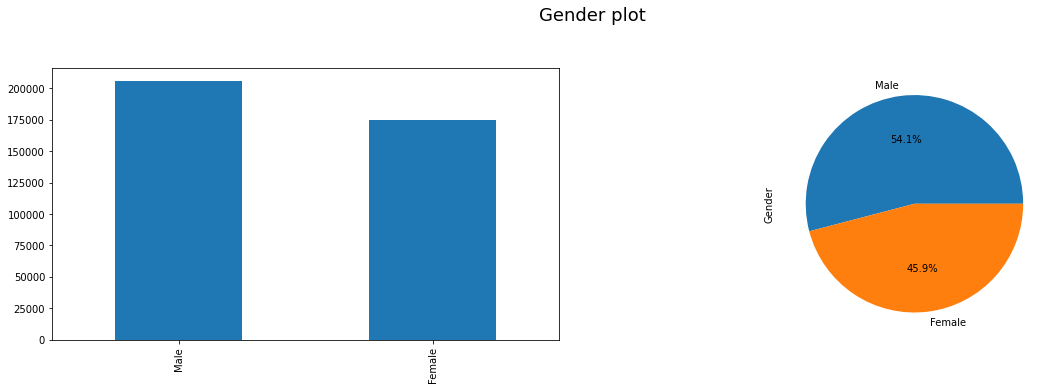

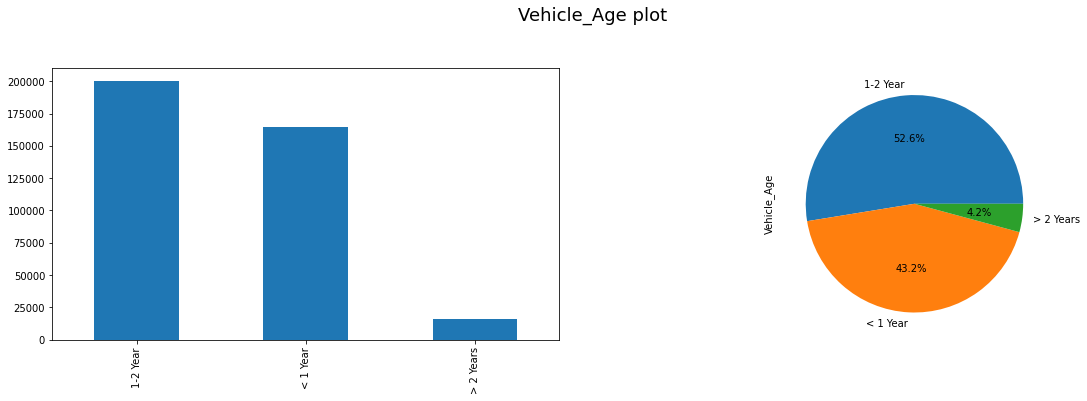

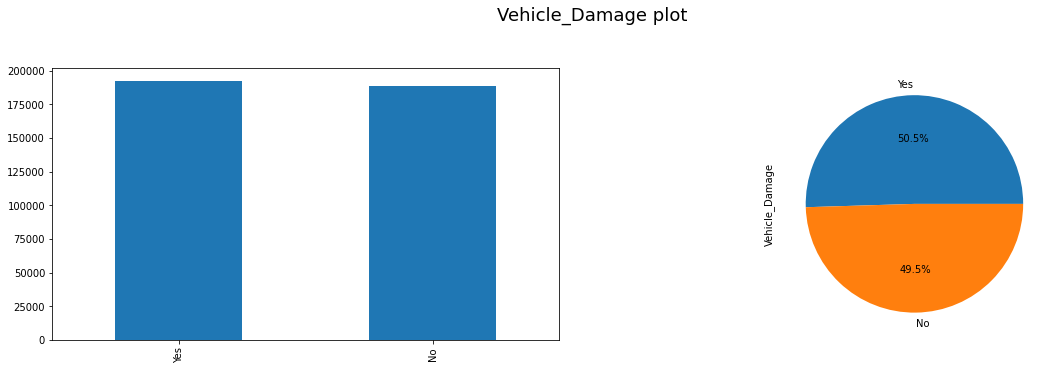

In [ ]:
for feature in categorical_features:
  fig, ax = plt.subplots(1,2,figsize=(20, 5))
  df[feature].value_counts().plot(kind='bar',ax=ax[0])
  df[feature].value_counts().plot(kind='pie', autopct='%1.1f%%',ax=ax[1])
  plt.suptitle(f'{feature} plot', y=1.05, fontsize=18)
  fig.show()

#### Observation in categorical features
  - Vehical age had an uneven distribution of classes 

In [32]:
for category in df['Vehicle_Age'].unique():
  print(f'Mean of {category} for Annual_Premium', df[(df['Vehicle_Age'] == category) & (df['Response'] == 1)]['Annual_Premium'].mean(),'for response 1',df[(df['Vehicle_Age'] == category) & (df['Response'] == 0)]['Annual_Premium'].mean(),'for response 0')
  print(f'Standard deviation of {category} for Annual_Premium', df[(df['Vehicle_Age'] == category) & (df['Response'] == 1)]['Annual_Premium'].std(),'for response 1',df[(df['Vehicle_Age'] == category) & (df['Response'] == 0)]['Annual_Premium'].std(),'for response 0')
  print(f'Variance of {category} for Annual_Premium', df[(df['Vehicle_Age'] == category) & (df['Response'] == 1)]['Annual_Premium'].var(),'for response 1',df[(df['Vehicle_Age'] == category) & (df['Response'] == 0)]['Annual_Premium'].mean(),'for response 0')
  print()

Mean of > 2 Years for Annual_Premium 38236.02084219481 for response 1 34580.787527642635 for response 0
Standard deviation of > 2 Years for Annual_Premium 19440.3047463162 for response 1 20292.447672575145 for response 0
Variance of > 2 Years for Annual_Premium 377925448.6296442 for response 1 34580.787527642635 for response 0

Mean of 1-2 Year for Annual_Premium 31075.800264322243 for response 1 30407.45315690895 for response 0
Standard deviation of 1-2 Year for Annual_Premium 18684.152068684114 for response 1 18540.349365452777 for response 0
Variance of 1-2 Year for Annual_Premium 349097538.5257129 for response 1 30407.45315690895 for response 0

Mean of < 1 Year for Annual_Premium 29827.422660372118 for response 1 30132.903099299423 for response 0
Standard deviation of < 1 Year for Annual_Premium 16971.5827349102 for response 1 14874.481767498606 for response 0
Variance of < 1 Year for Annual_Premium 288034620.52790195 for response 1 30132.903099299423 for response 0



#### Observation 
  - We had comparied `vehicle age`, `Annual Premium` mean, std and var in terms of `Response` 
  - There not much of a difference in there `mean`, `std` and `variance`.
  - so we can say that the age of vehicle for both `response 1` and `response 0` is unbiased
  - we can conclude that even though the distribution of vehicle age category is imbalance but the relation with target column i.e `response` is balanced

### Bivarient Analysis
  - We are going to investigate about outlier and will they play any importance in our prediction or we can remove them completely.

In [86]:
# Annual Premium 5 number summary
def getsummary(feature):
  Q3 = np.percentile(df[feature], 75, axis=0)
  Q1 = np.percentile(df[feature], 25, axis=0)
  IQR = Q3-Q1
  upper_bound = Q3 + 1.5 * IQR
  lower_bound = Q1 - 1.5 * IQR
  return (Q1,Q3,IQR,upper_bound,lower_bound)

Age Age
Q1 : 25.0  Q3 : 49.0  IQR : 24.0 upper_bound : 85.0  lower_bound : -11.0
fig 0.0


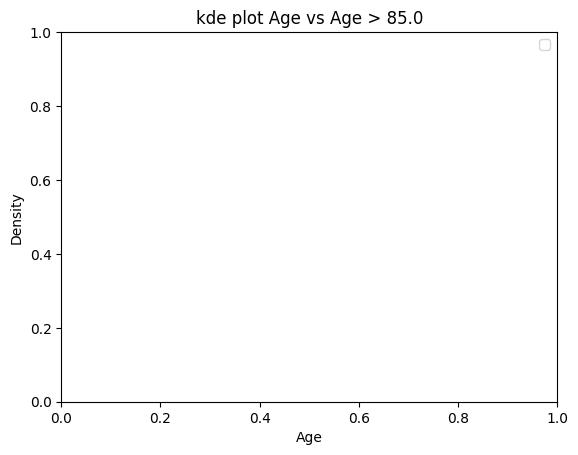

Age Driving_License
Q1 : 25.0  Q3 : 49.0  IQR : 24.0 upper_bound : 85.0  lower_bound : -11.0
fig 0.1


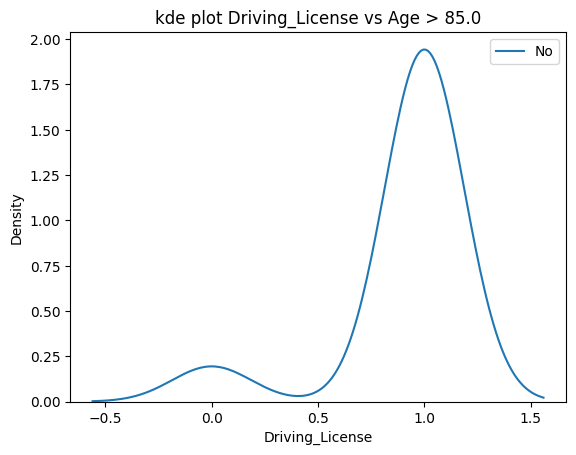

Age Region_Code
Q1 : 25.0  Q3 : 49.0  IQR : 24.0 upper_bound : 85.0  lower_bound : -11.0
fig 0.2


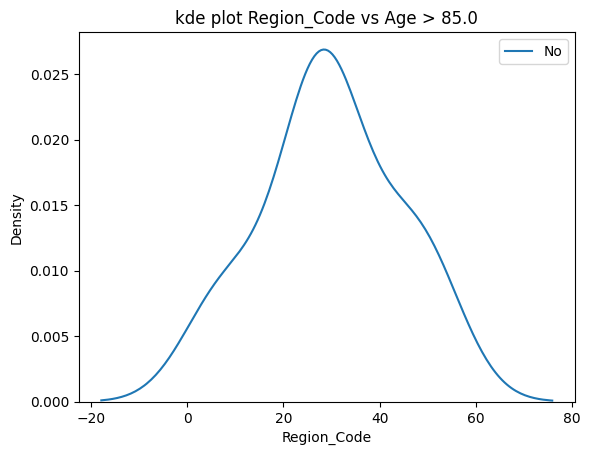

Age Previously_Insured
Q1 : 25.0  Q3 : 49.0  IQR : 24.0 upper_bound : 85.0  lower_bound : -11.0
fig 0.3


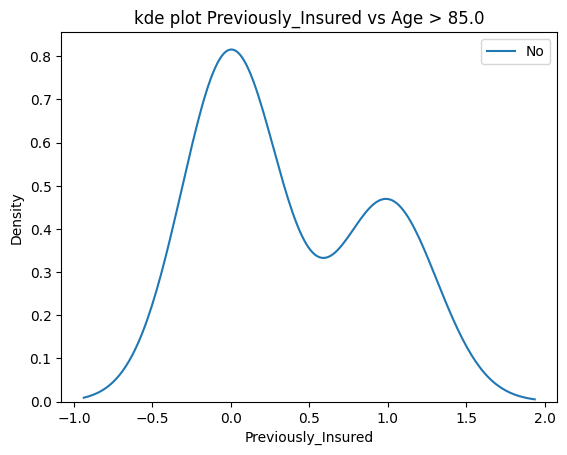

Age Annual_Premium
Q1 : 25.0  Q3 : 49.0  IQR : 24.0 upper_bound : 85.0  lower_bound : -11.0
fig 0.4


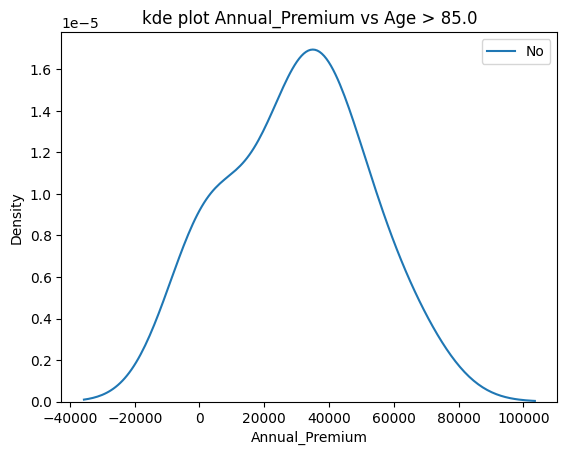

Age Policy_Sales_Channel
Q1 : 25.0  Q3 : 49.0  IQR : 24.0 upper_bound : 85.0  lower_bound : -11.0
fig 0.5


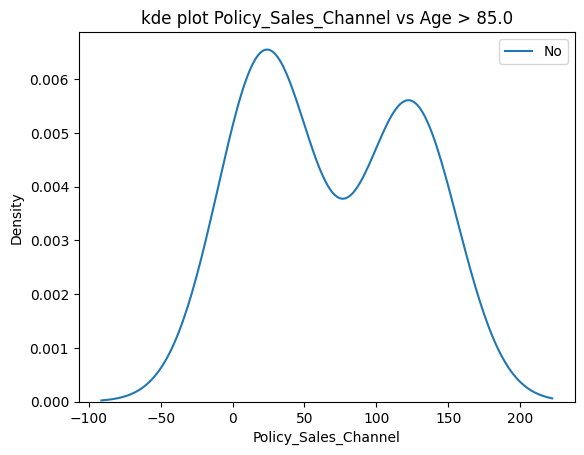

Age Vintage
Q1 : 25.0  Q3 : 49.0  IQR : 24.0 upper_bound : 85.0  lower_bound : -11.0
fig 0.6


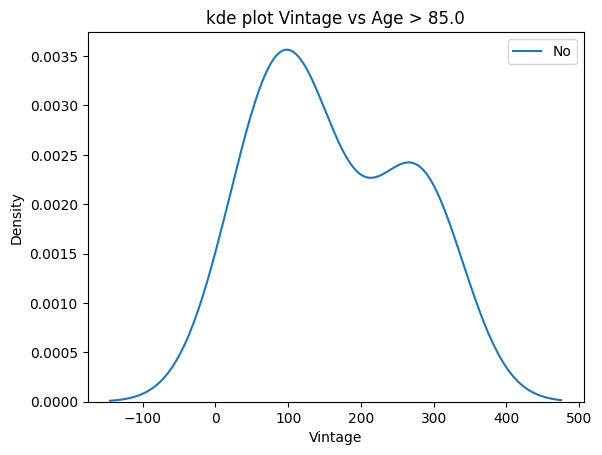

Driving_License Age
Q1 : 1.0  Q3 : 1.0  IQR : 0.0 upper_bound : 1.0  lower_bound : 1.0
fig 1.0


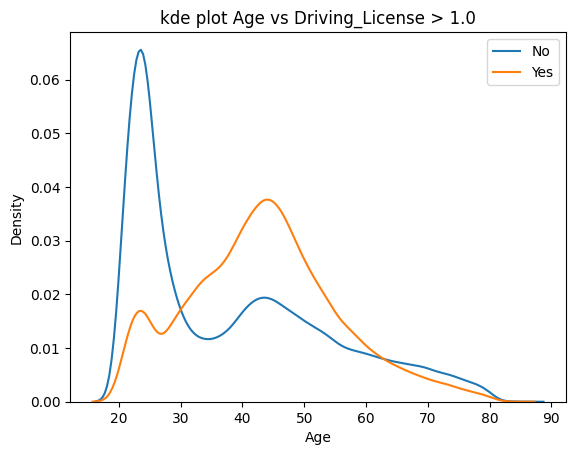

Driving_License Driving_License
Q1 : 1.0  Q3 : 1.0  IQR : 0.0 upper_bound : 1.0  lower_bound : 1.0
fig 1.1


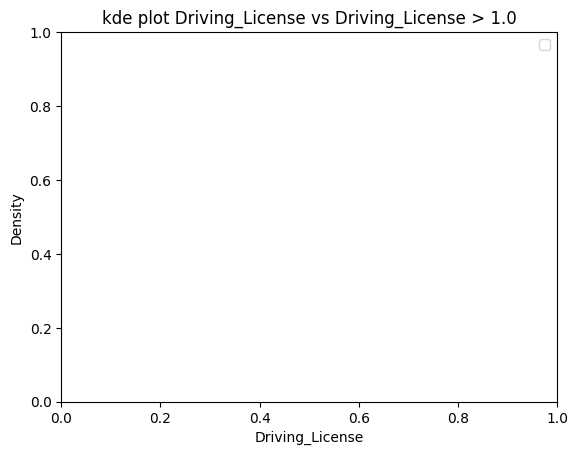

Driving_License Region_Code
Q1 : 1.0  Q3 : 1.0  IQR : 0.0 upper_bound : 1.0  lower_bound : 1.0
fig 1.2


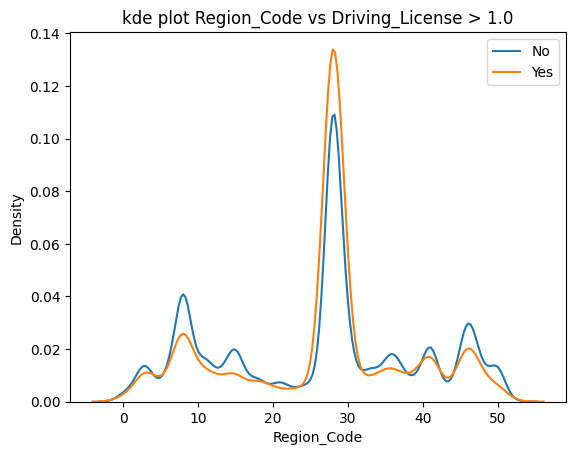

Driving_License Previously_Insured
Q1 : 1.0  Q3 : 1.0  IQR : 0.0 upper_bound : 1.0  lower_bound : 1.0
fig 1.3


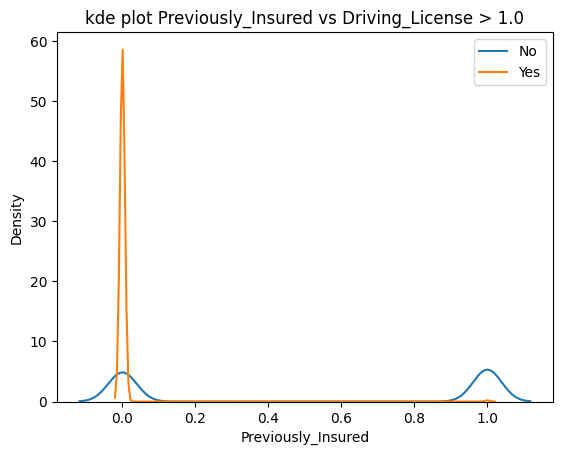

Driving_License Annual_Premium
Q1 : 1.0  Q3 : 1.0  IQR : 0.0 upper_bound : 1.0  lower_bound : 1.0
fig 1.4


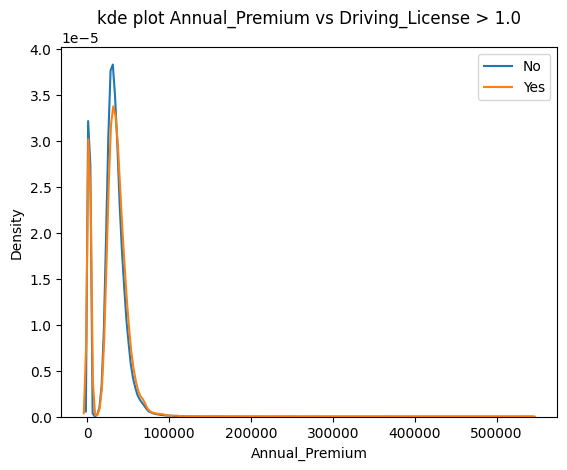

Driving_License Policy_Sales_Channel
Q1 : 1.0  Q3 : 1.0  IQR : 0.0 upper_bound : 1.0  lower_bound : 1.0
fig 1.5


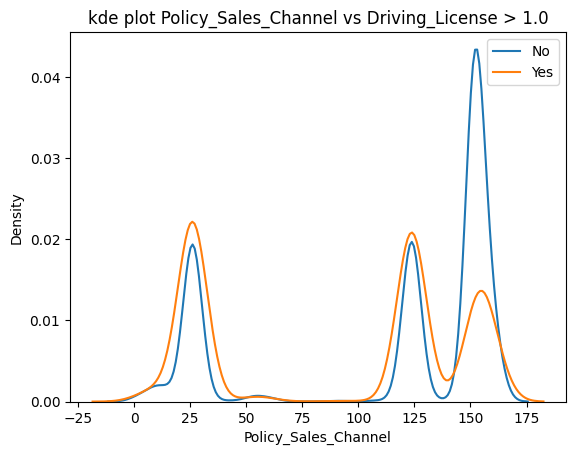

Driving_License Vintage
Q1 : 1.0  Q3 : 1.0  IQR : 0.0 upper_bound : 1.0  lower_bound : 1.0
fig 1.6


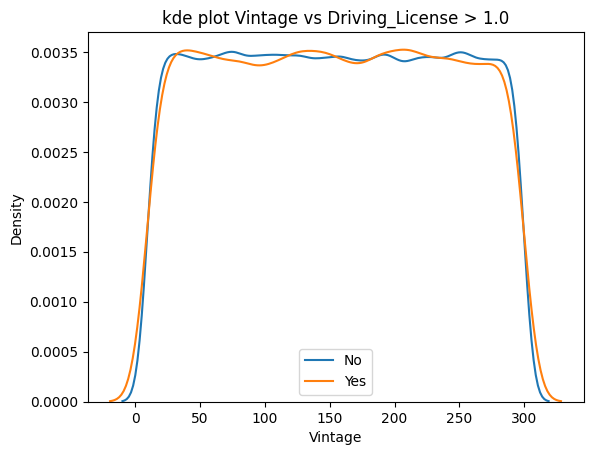

Region_Code Age
Q1 : 15.0  Q3 : 35.0  IQR : 20.0 upper_bound : 65.0  lower_bound : -15.0
fig 2.0


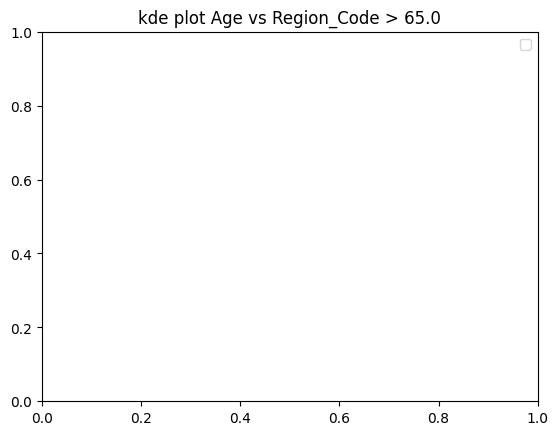

Region_Code Driving_License
Q1 : 15.0  Q3 : 35.0  IQR : 20.0 upper_bound : 65.0  lower_bound : -15.0
fig 2.1


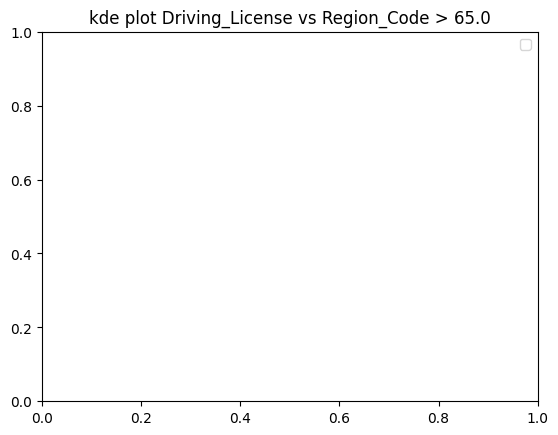

Region_Code Region_Code
Q1 : 15.0  Q3 : 35.0  IQR : 20.0 upper_bound : 65.0  lower_bound : -15.0
fig 2.2


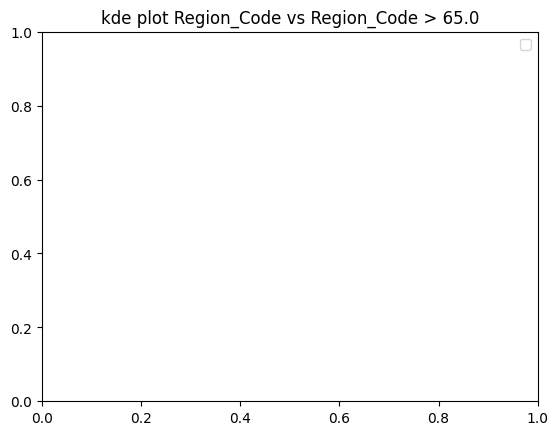

Region_Code Previously_Insured
Q1 : 15.0  Q3 : 35.0  IQR : 20.0 upper_bound : 65.0  lower_bound : -15.0
fig 2.3


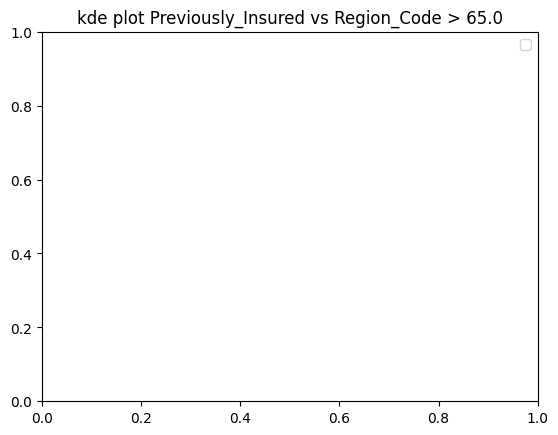

Region_Code Annual_Premium
Q1 : 15.0  Q3 : 35.0  IQR : 20.0 upper_bound : 65.0  lower_bound : -15.0
fig 2.4


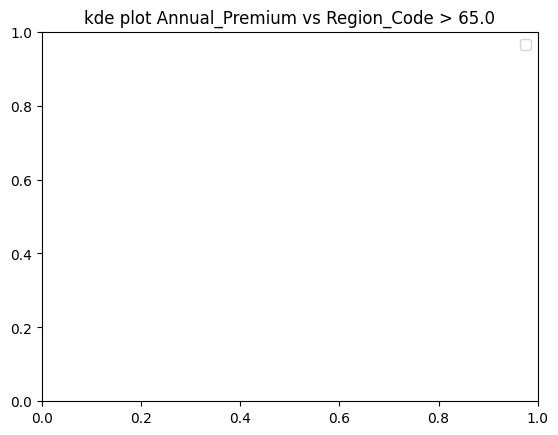

Region_Code Policy_Sales_Channel
Q1 : 15.0  Q3 : 35.0  IQR : 20.0 upper_bound : 65.0  lower_bound : -15.0
fig 2.5


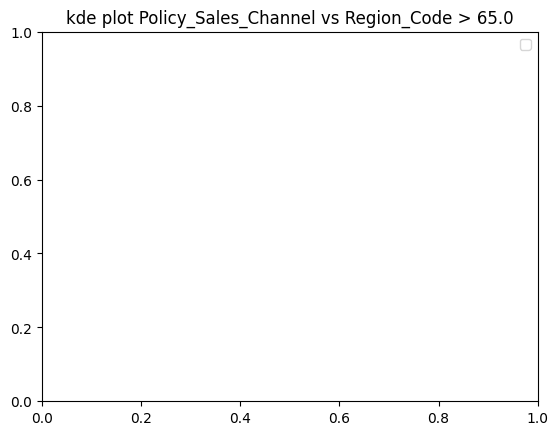

Region_Code Vintage
Q1 : 15.0  Q3 : 35.0  IQR : 20.0 upper_bound : 65.0  lower_bound : -15.0
fig 2.6


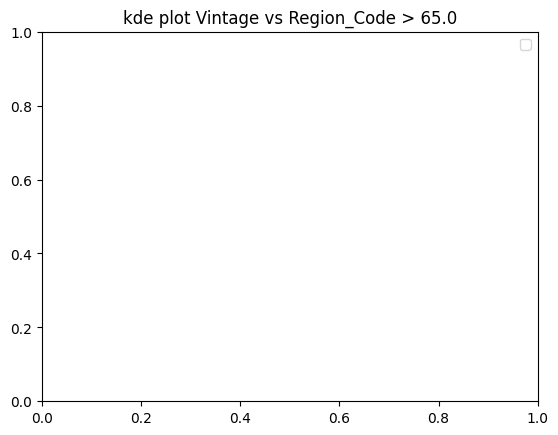

Previously_Insured Age
Q1 : 0.0  Q3 : 1.0  IQR : 1.0 upper_bound : 2.5  lower_bound : -1.5
fig 3.0


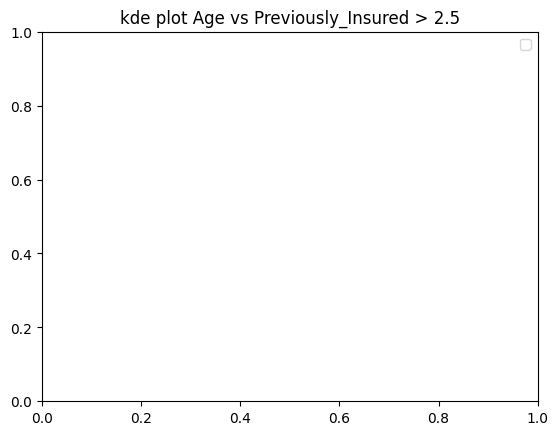

Previously_Insured Driving_License
Q1 : 0.0  Q3 : 1.0  IQR : 1.0 upper_bound : 2.5  lower_bound : -1.5
fig 3.1


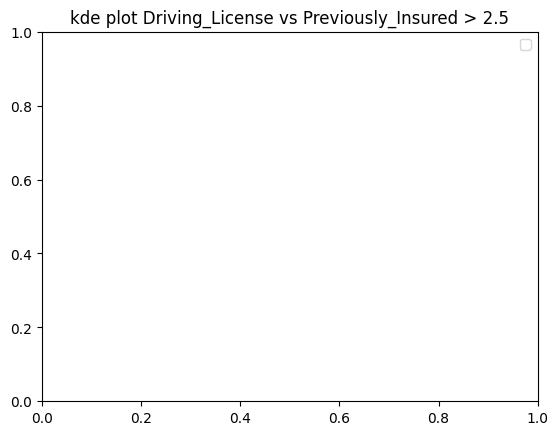

Previously_Insured Region_Code
Q1 : 0.0  Q3 : 1.0  IQR : 1.0 upper_bound : 2.5  lower_bound : -1.5
fig 3.2


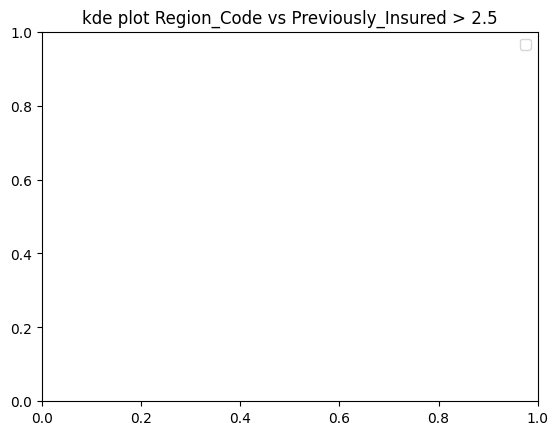

Previously_Insured Previously_Insured
Q1 : 0.0  Q3 : 1.0  IQR : 1.0 upper_bound : 2.5  lower_bound : -1.5
fig 3.3


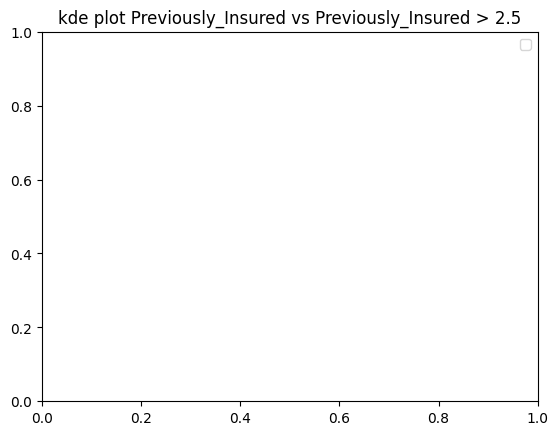

Previously_Insured Annual_Premium
Q1 : 0.0  Q3 : 1.0  IQR : 1.0 upper_bound : 2.5  lower_bound : -1.5
fig 3.4


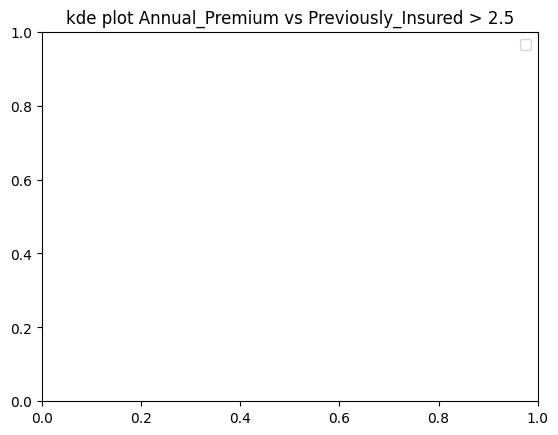

Previously_Insured Policy_Sales_Channel
Q1 : 0.0  Q3 : 1.0  IQR : 1.0 upper_bound : 2.5  lower_bound : -1.5
fig 3.5


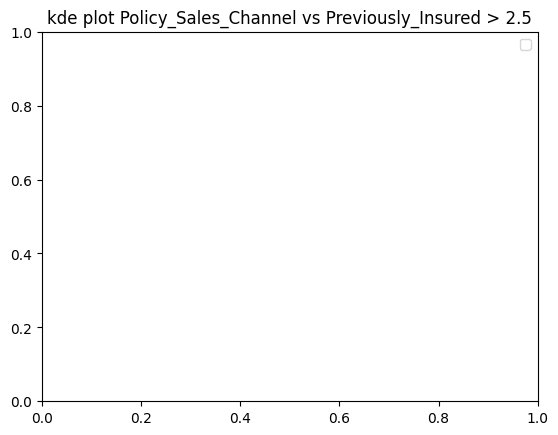

Previously_Insured Vintage
Q1 : 0.0  Q3 : 1.0  IQR : 1.0 upper_bound : 2.5  lower_bound : -1.5
fig 3.6


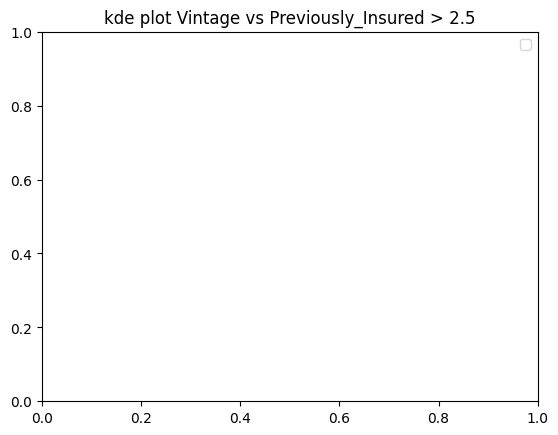

Annual_Premium Age
Q1 : 24405.0  Q3 : 39400.0  IQR : 14995.0 upper_bound : 61892.5  lower_bound : 1912.5
fig 4.0


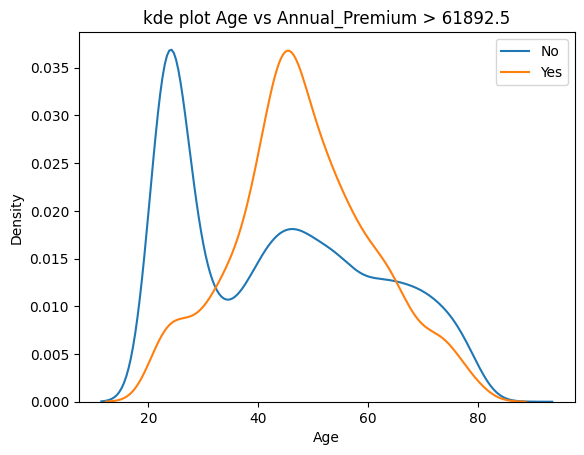

Annual_Premium Driving_License
Q1 : 24405.0  Q3 : 39400.0  IQR : 14995.0 upper_bound : 61892.5  lower_bound : 1912.5
fig 4.1


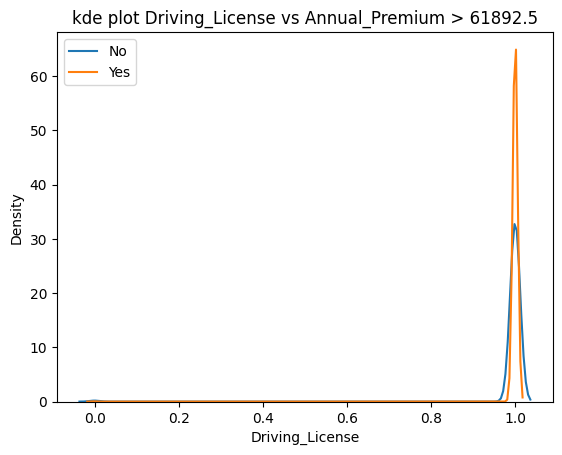

Annual_Premium Region_Code
Q1 : 24405.0  Q3 : 39400.0  IQR : 14995.0 upper_bound : 61892.5  lower_bound : 1912.5
fig 4.2


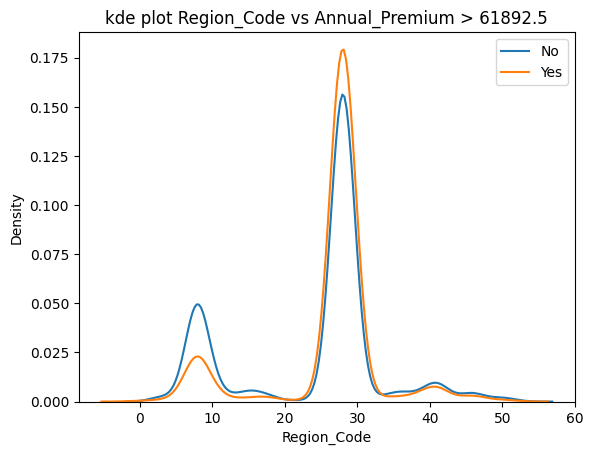

Annual_Premium Previously_Insured
Q1 : 24405.0  Q3 : 39400.0  IQR : 14995.0 upper_bound : 61892.5  lower_bound : 1912.5
fig 4.3


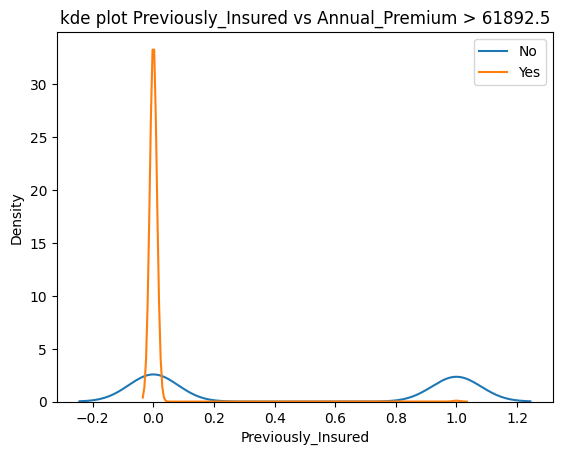

Annual_Premium Annual_Premium
Q1 : 24405.0  Q3 : 39400.0  IQR : 14995.0 upper_bound : 61892.5  lower_bound : 1912.5
fig 4.4


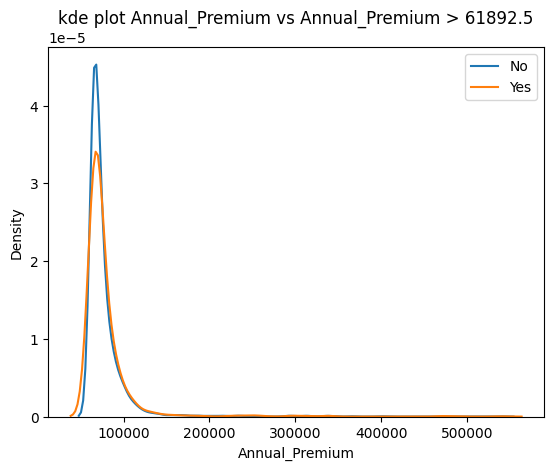

Annual_Premium Policy_Sales_Channel
Q1 : 24405.0  Q3 : 39400.0  IQR : 14995.0 upper_bound : 61892.5  lower_bound : 1912.5
fig 4.5


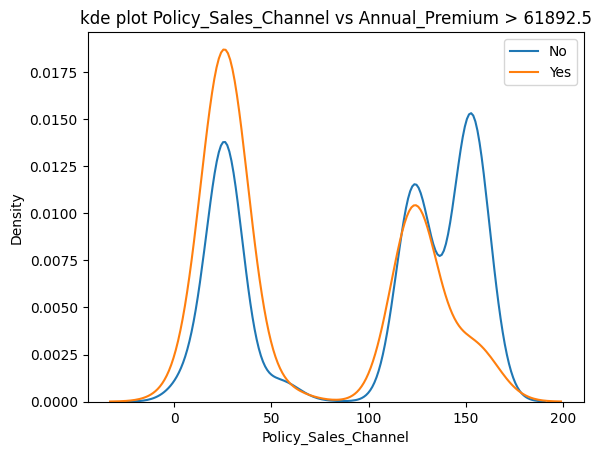

Annual_Premium Vintage
Q1 : 24405.0  Q3 : 39400.0  IQR : 14995.0 upper_bound : 61892.5  lower_bound : 1912.5
fig 4.6


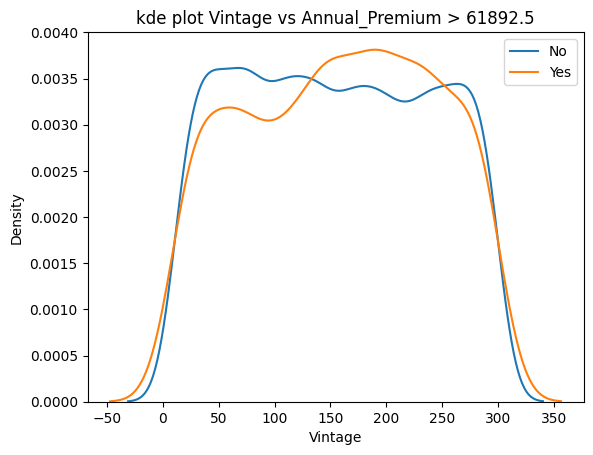

Policy_Sales_Channel Age
Q1 : 29.0  Q3 : 152.0  IQR : 123.0 upper_bound : 336.5  lower_bound : -155.5
fig 5.0


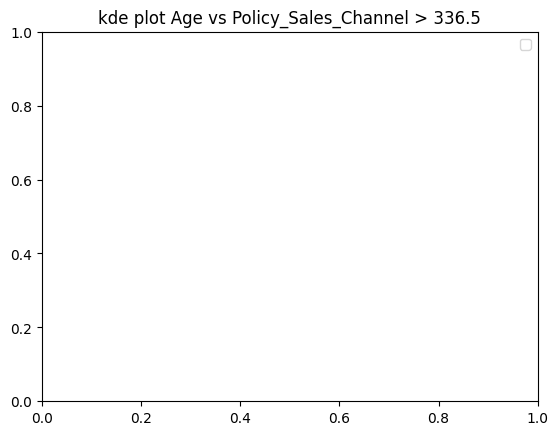

Policy_Sales_Channel Driving_License
Q1 : 29.0  Q3 : 152.0  IQR : 123.0 upper_bound : 336.5  lower_bound : -155.5
fig 5.1


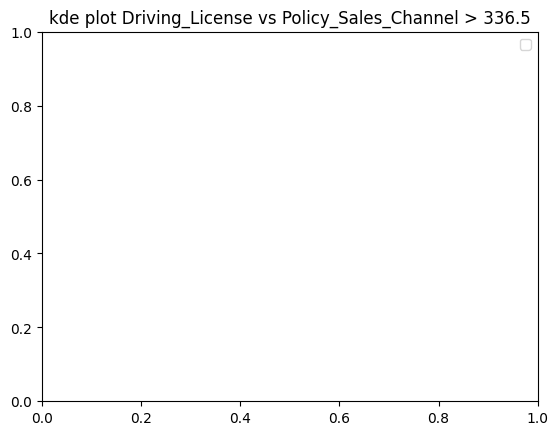

Policy_Sales_Channel Region_Code
Q1 : 29.0  Q3 : 152.0  IQR : 123.0 upper_bound : 336.5  lower_bound : -155.5
fig 5.2


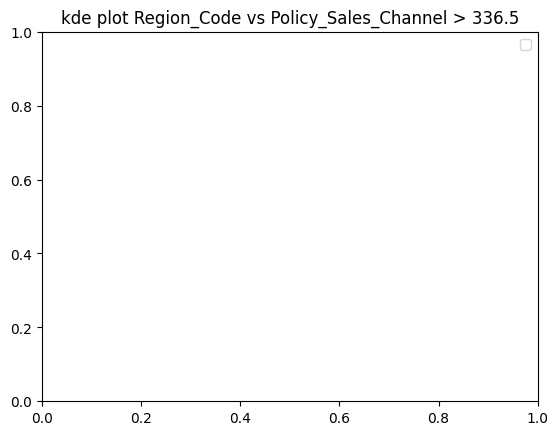

Policy_Sales_Channel Previously_Insured
Q1 : 29.0  Q3 : 152.0  IQR : 123.0 upper_bound : 336.5  lower_bound : -155.5
fig 5.3


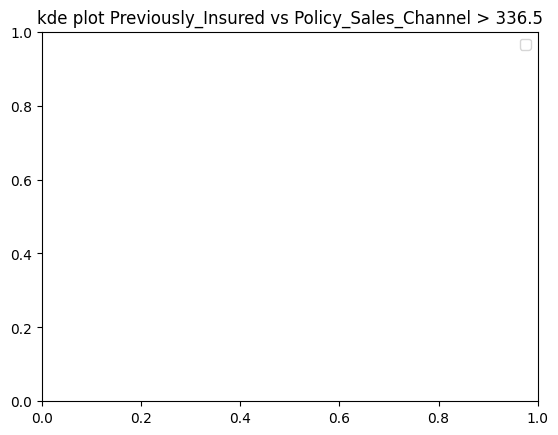

Policy_Sales_Channel Annual_Premium
Q1 : 29.0  Q3 : 152.0  IQR : 123.0 upper_bound : 336.5  lower_bound : -155.5
fig 5.4


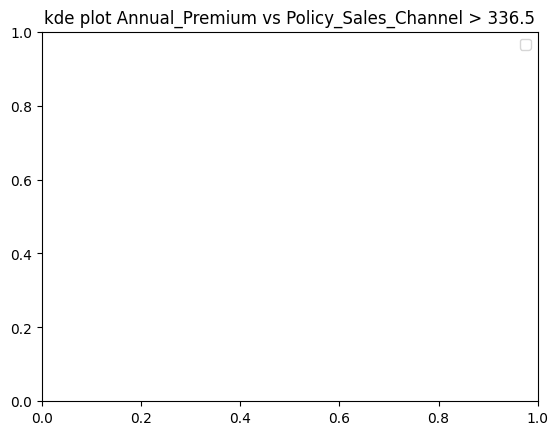

Policy_Sales_Channel Policy_Sales_Channel
Q1 : 29.0  Q3 : 152.0  IQR : 123.0 upper_bound : 336.5  lower_bound : -155.5
fig 5.5


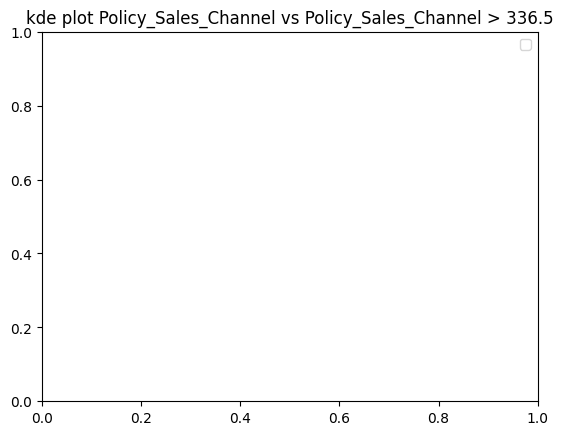

Policy_Sales_Channel Vintage
Q1 : 29.0  Q3 : 152.0  IQR : 123.0 upper_bound : 336.5  lower_bound : -155.5
fig 5.6


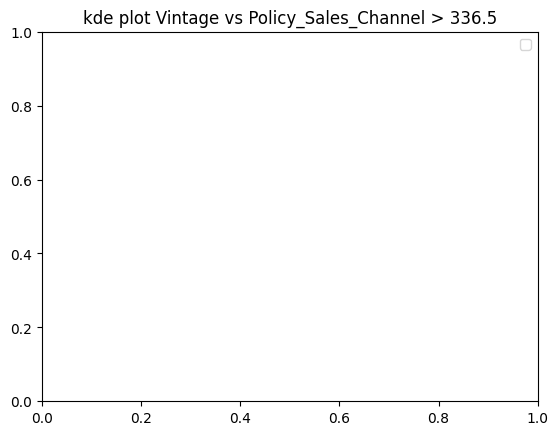

Vintage Age
Q1 : 82.0  Q3 : 227.0  IQR : 145.0 upper_bound : 444.5  lower_bound : -135.5
fig 6.0


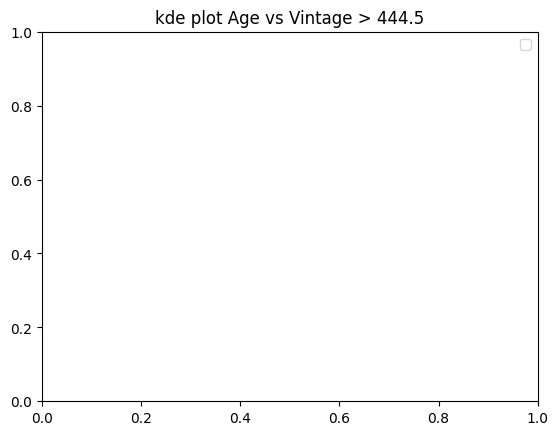

Vintage Driving_License
Q1 : 82.0  Q3 : 227.0  IQR : 145.0 upper_bound : 444.5  lower_bound : -135.5
fig 6.1


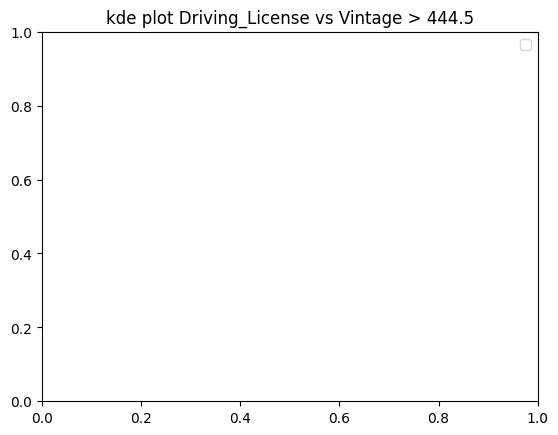

Vintage Region_Code
Q1 : 82.0  Q3 : 227.0  IQR : 145.0 upper_bound : 444.5  lower_bound : -135.5
fig 6.2


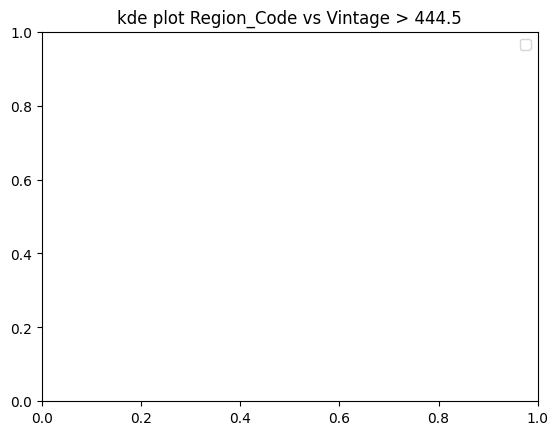

Vintage Previously_Insured
Q1 : 82.0  Q3 : 227.0  IQR : 145.0 upper_bound : 444.5  lower_bound : -135.5
fig 6.3


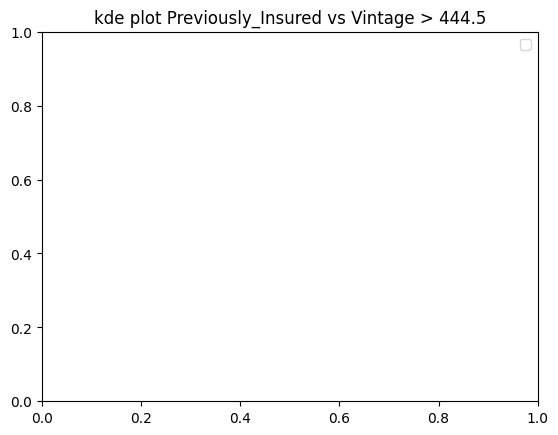

Vintage Annual_Premium
Q1 : 82.0  Q3 : 227.0  IQR : 145.0 upper_bound : 444.5  lower_bound : -135.5
fig 6.4


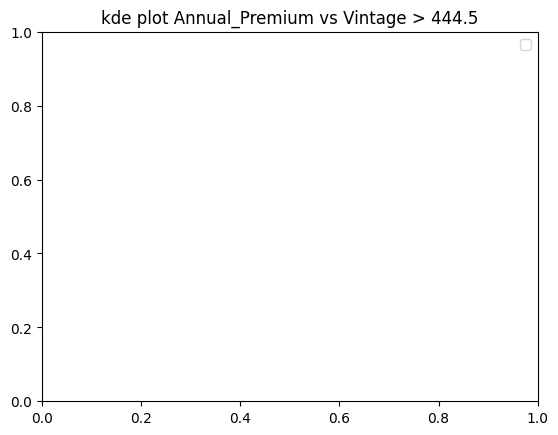

Vintage Policy_Sales_Channel
Q1 : 82.0  Q3 : 227.0  IQR : 145.0 upper_bound : 444.5  lower_bound : -135.5
fig 6.5


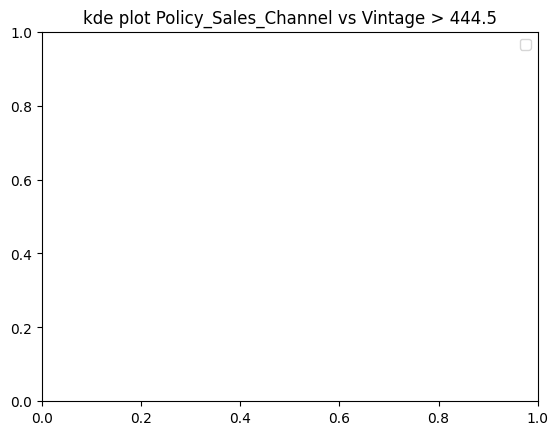

Vintage Vintage
Q1 : 82.0  Q3 : 227.0  IQR : 145.0 upper_bound : 444.5  lower_bound : -135.5
fig 6.6


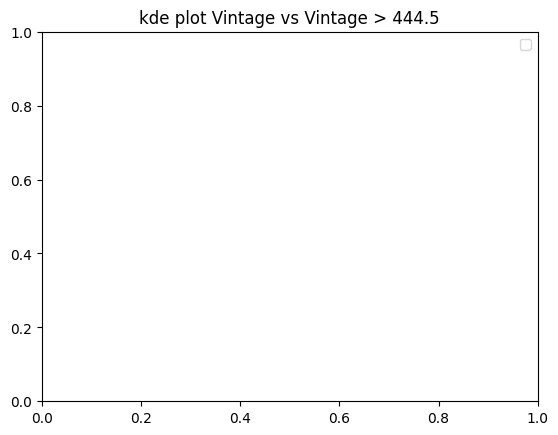

In [97]:
# Checking the outliers in all feature based on the target column and does it affext in some to our target column.  
# figure out is there any relation in terms of outlier values and the target column
# objective is to decide wheather to remove to oulier or we are getting any insites.
# fig 1.2
for i,left_feature in enumerate(numeric_features):
  for j,right_feature in enumerate(numeric_features):
    Q1,Q3,IQR,upper_bound,lower_bound = getsummary(left_feature)
    print(left_feature,right_feature)
    print('Q1 :',Q1,' Q3 :',Q3,' IQR :',IQR,'upper_bound :',upper_bound,' lower_bound :',lower_bound)
    print(f'fig {i}.{j}')
    sns.kdeplot(df[(df[left_feature] >= upper_bound) & (df['Response'] == 0)][right_feature])
    sns.kdeplot(df[(df[left_feature] >= upper_bound) & (df['Response'] == 1)][right_feature])
    plt.legend(labels=["No","Yes"])
    # displaying the title
    plt.title(f"kde plot {right_feature} vs {left_feature} > {upper_bound}")
    plt.show ()

#### Observation 
  
  - `Age`
    - Above upper bound the `Driving_License` for both 0 or 1 showing no interent in vehicle insurance (fig 0.1) 
    - Same responce = 0 means no interest in vehicle insurance for `Previous_isure`, `Annual_Premium`, `Policy_sales_channel`,`vintage` fig (0.2 - 0.6) 
    - `Age` in range `18 - 35` and `Annual premium > 61892.5` not interested in Vehicle Insurance.
    - where as `Age` in range `35 - 75` and `Annual premium > 61892.5` are showing more interested in Vehicle Insurance. fig(4.0)
    - `Age` in range `32 to 65` with `Driving Licence` shows interest in vehicle insaurance fig(4.0)
    - `Age` in range `18 to 30` with `Driving Licence` not interested in Vehicle Insurance.

  - `Drivinf_License`
    -  `Driving_License` is 1 and and `Annual premium > 61892.5` shows interested in Vehicle Insurance. fig(4.1)
  
  - `Region_Code` 
    - `Region_Code ` in range `25 - 32` with `Driving_License` shows interested in Vehicle Insurance. fig (1.2)
    -  `Region_Code` is range `0 - 20` and and `Annual premium > 61892.5` shows no interested in Vehicle Insurance. fig(4.2)   
    -  `Region_Code` is range `20 - 35` and and `Annual premium > 61892.5` shows interested in Vehicle Insurance. fig(4.2)
  
  - `Previously_Insured`
    - `Previously_Insured` is yes with `Driving_License` shows interested in Vehicle Insurance. fig (1.3)
    -  `Previously_Insured` is yes and and `Annual premium > 61892.5` shows interested in Vehicle Insurance.    
    - So we can target those customer who have `Previously_Insured` and `Annual premium > 61892.5` fig(4.3)
  
  - `Policy_Sales_Channel `
    - `Policy_Sales_Channel` with `Driving_License` most likely interested in Vehicle Insurance.  fig(1.5)
    -  `Policy_Sales_Channel` is `range 0 - 55` and and `Annual premium > 61892.5` shows interested in Vehicle Insurance. fig(4.5)
  - fig 1.6
    -  `Vintage` is `range 150 - 280` and and `Annual premium > 61892.5` shows interested in Vehicle Insurance. fig(4.6)  

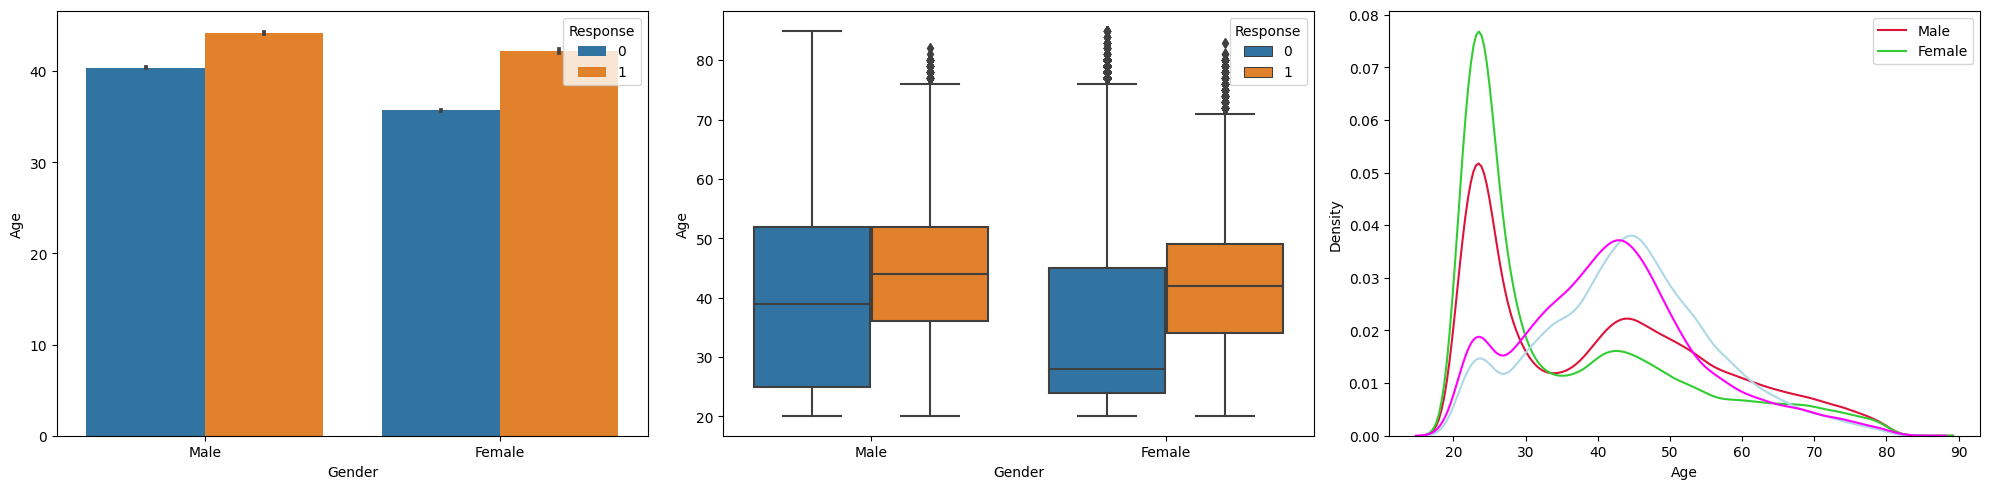

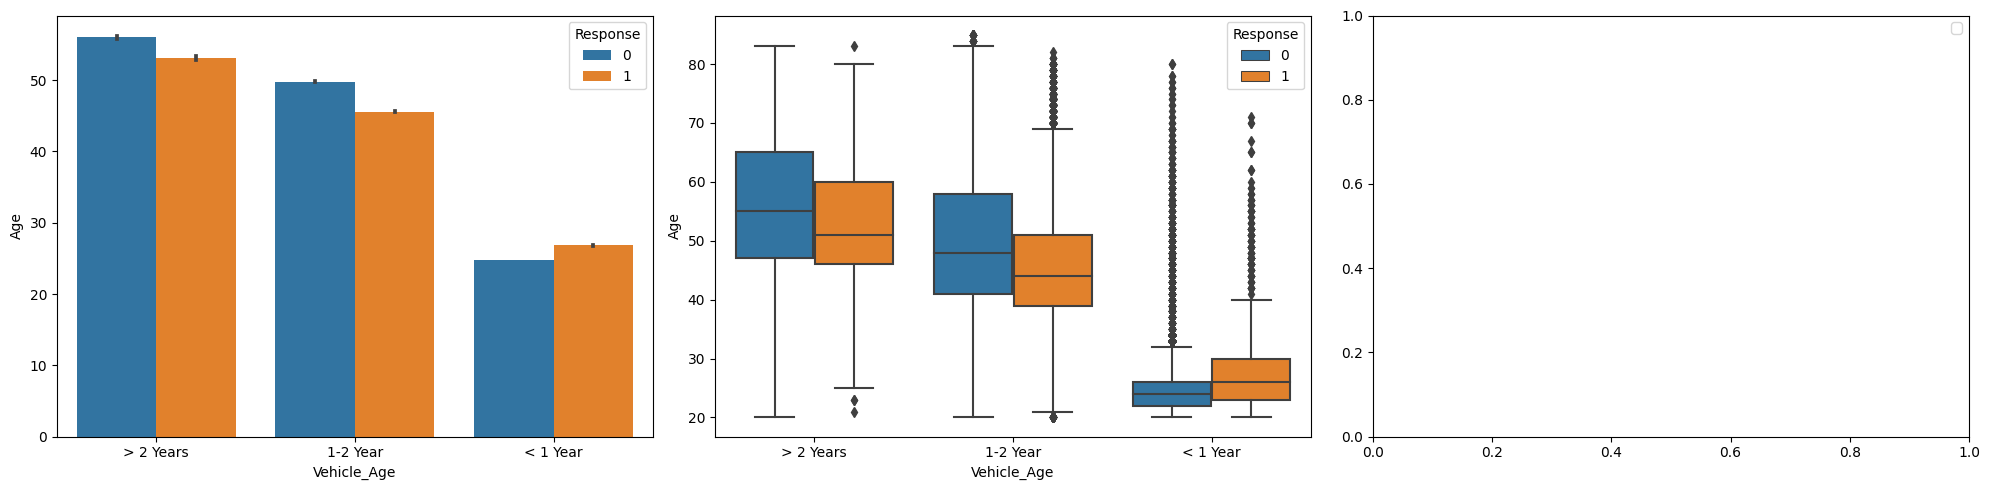

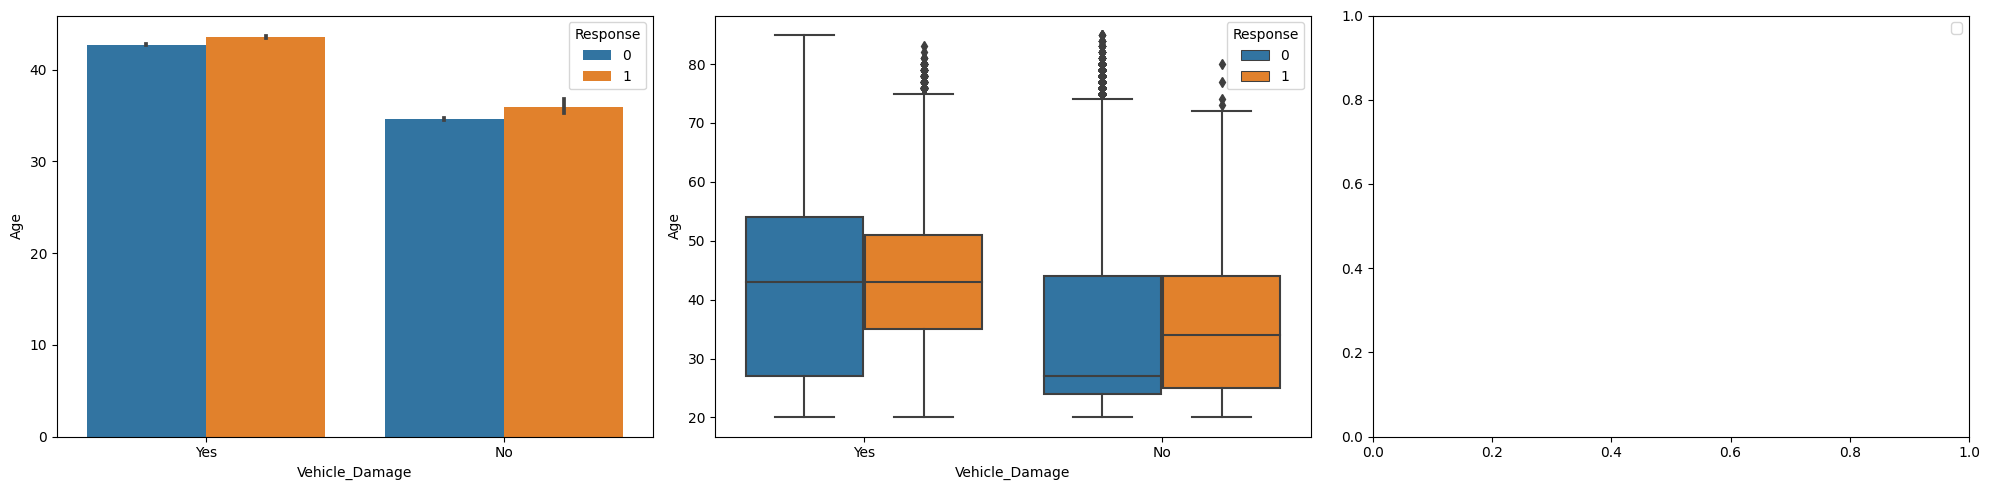

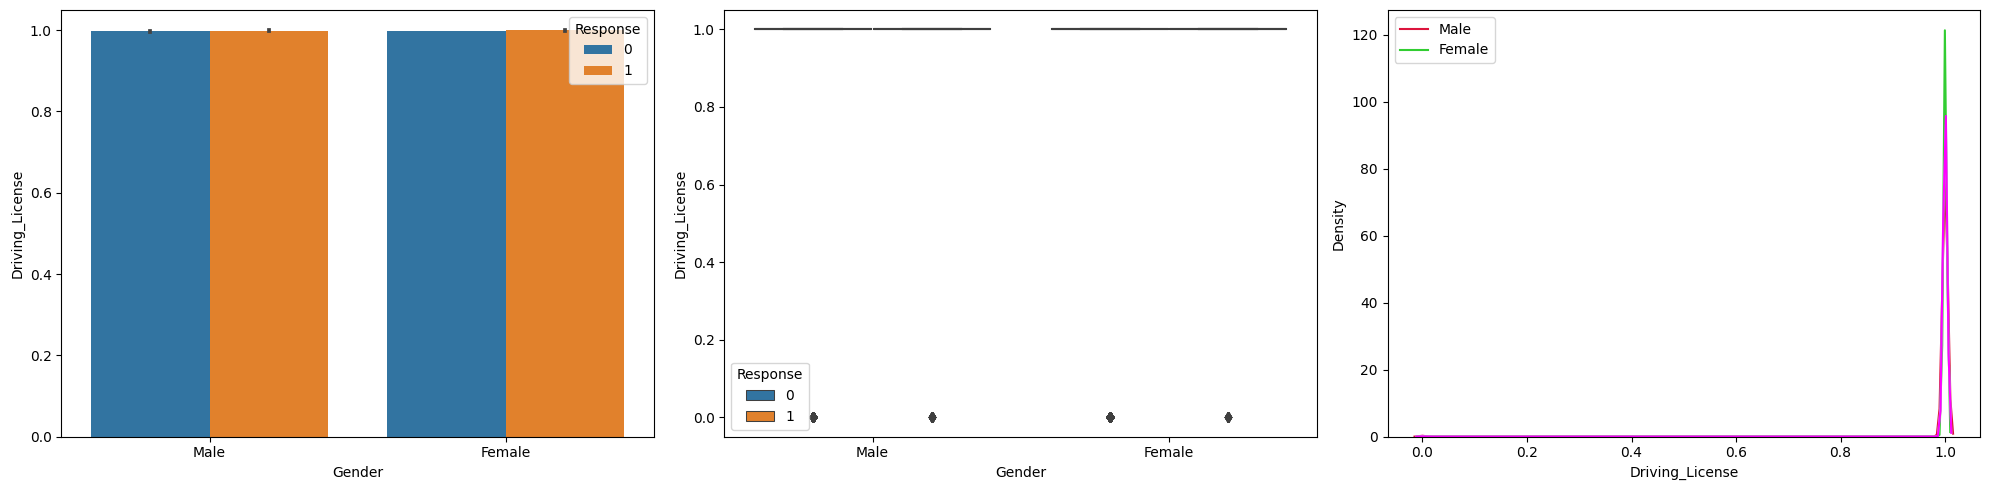

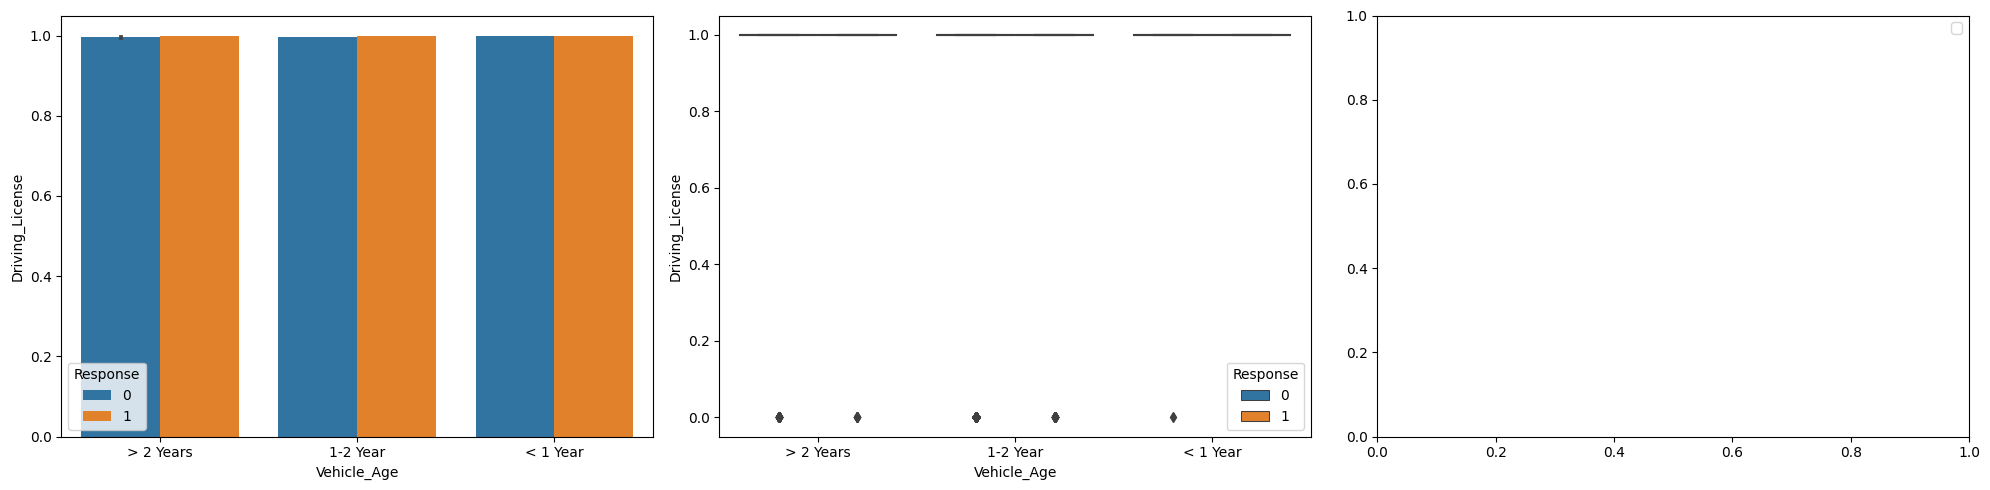

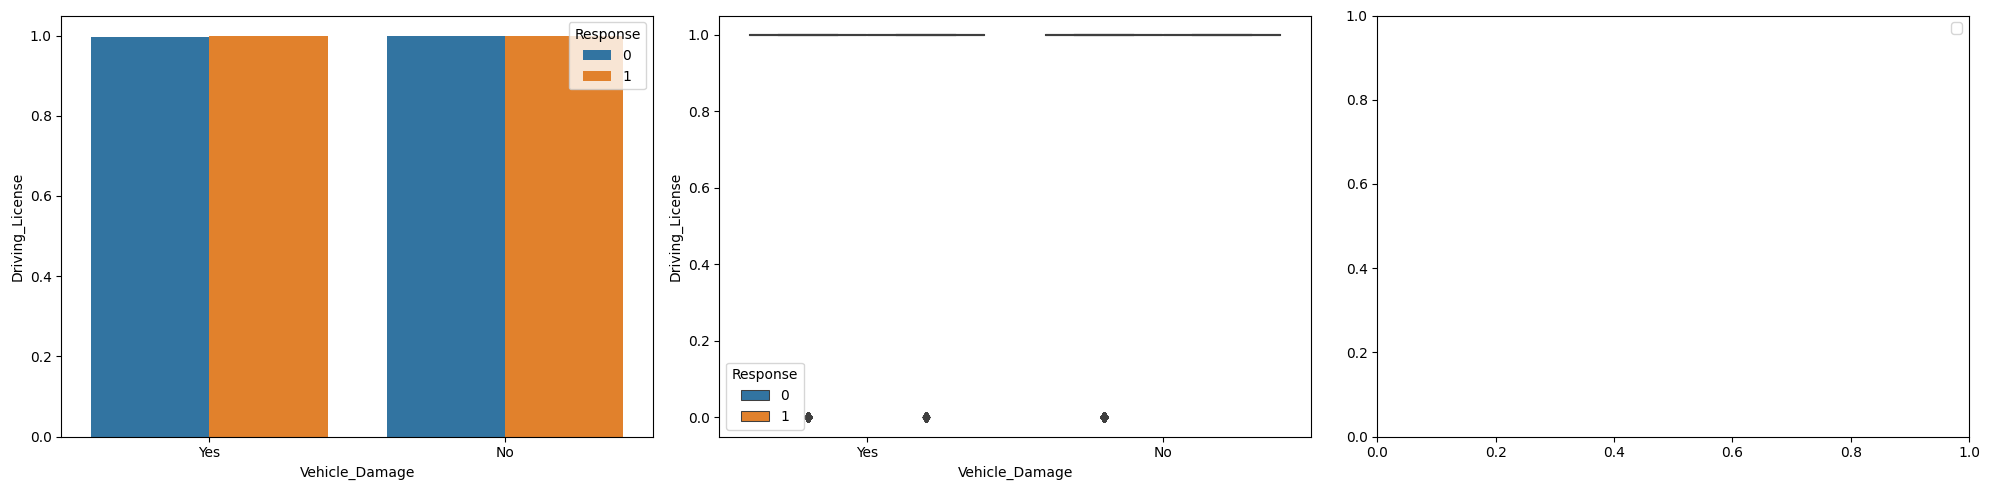

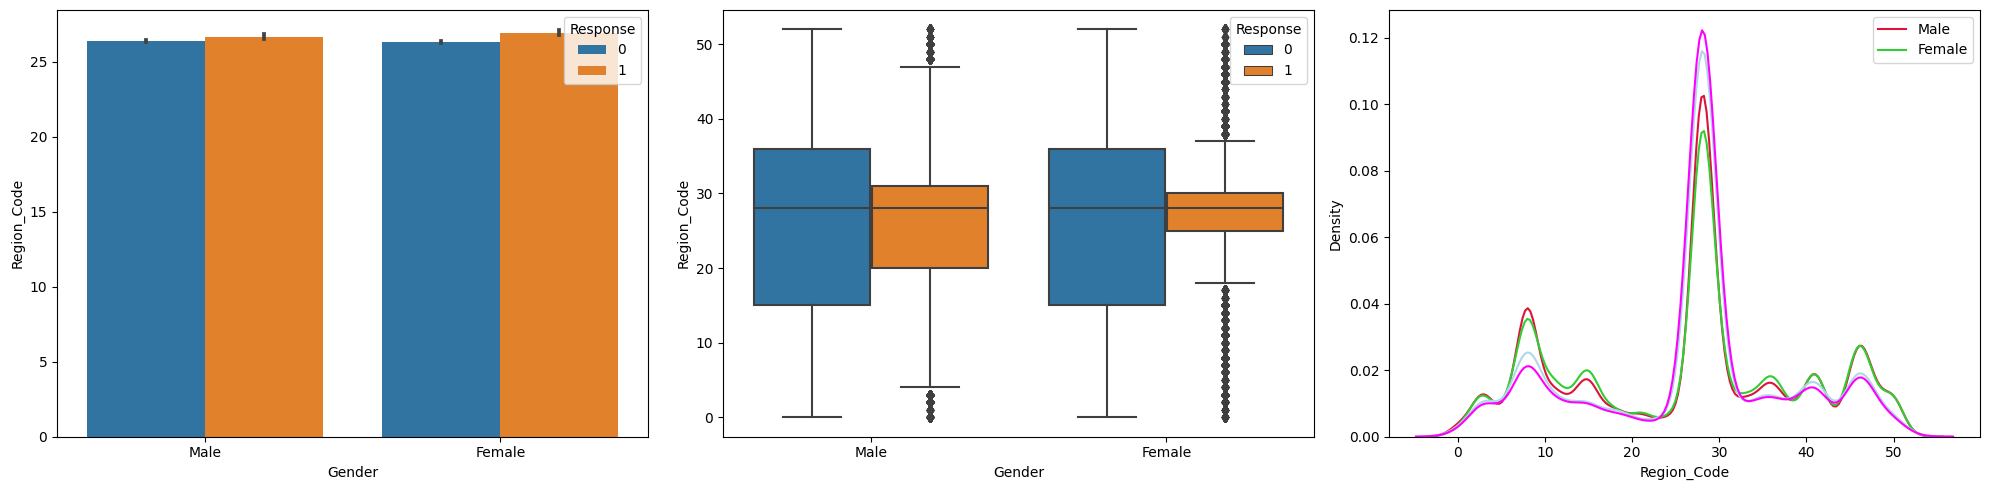

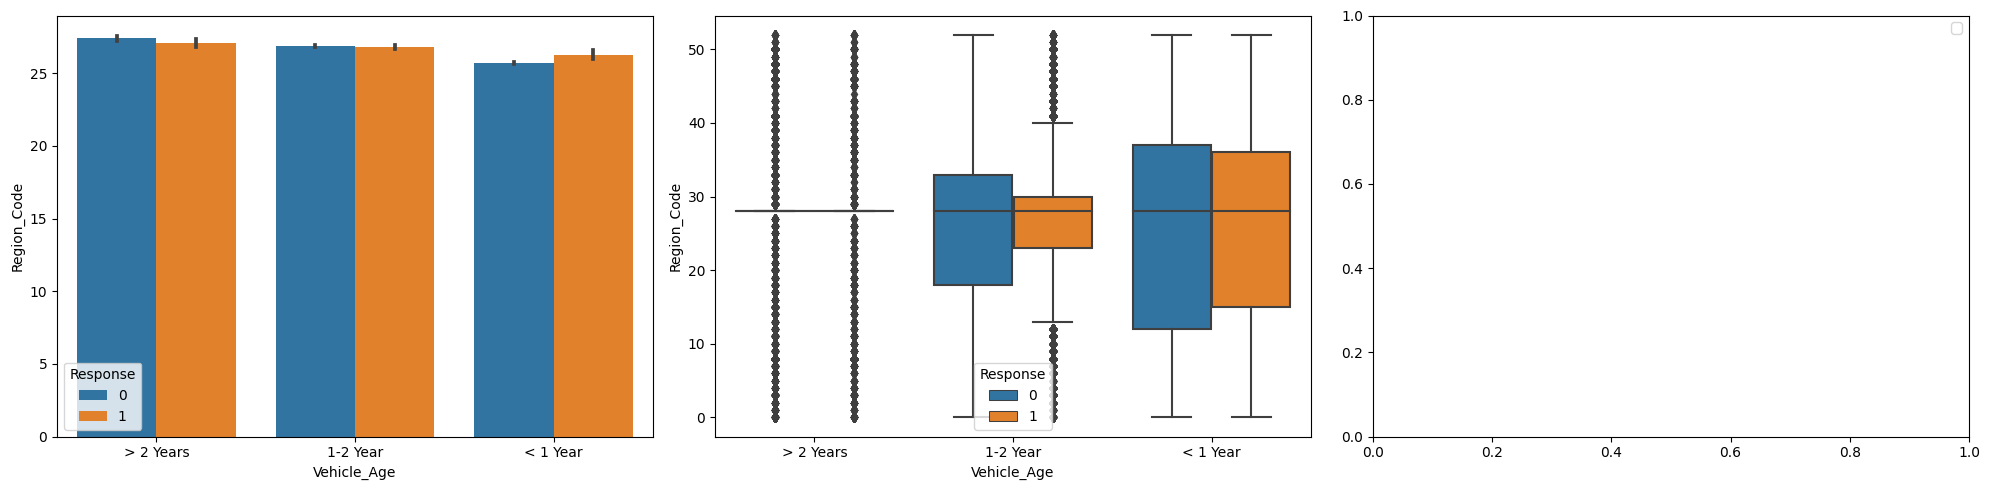

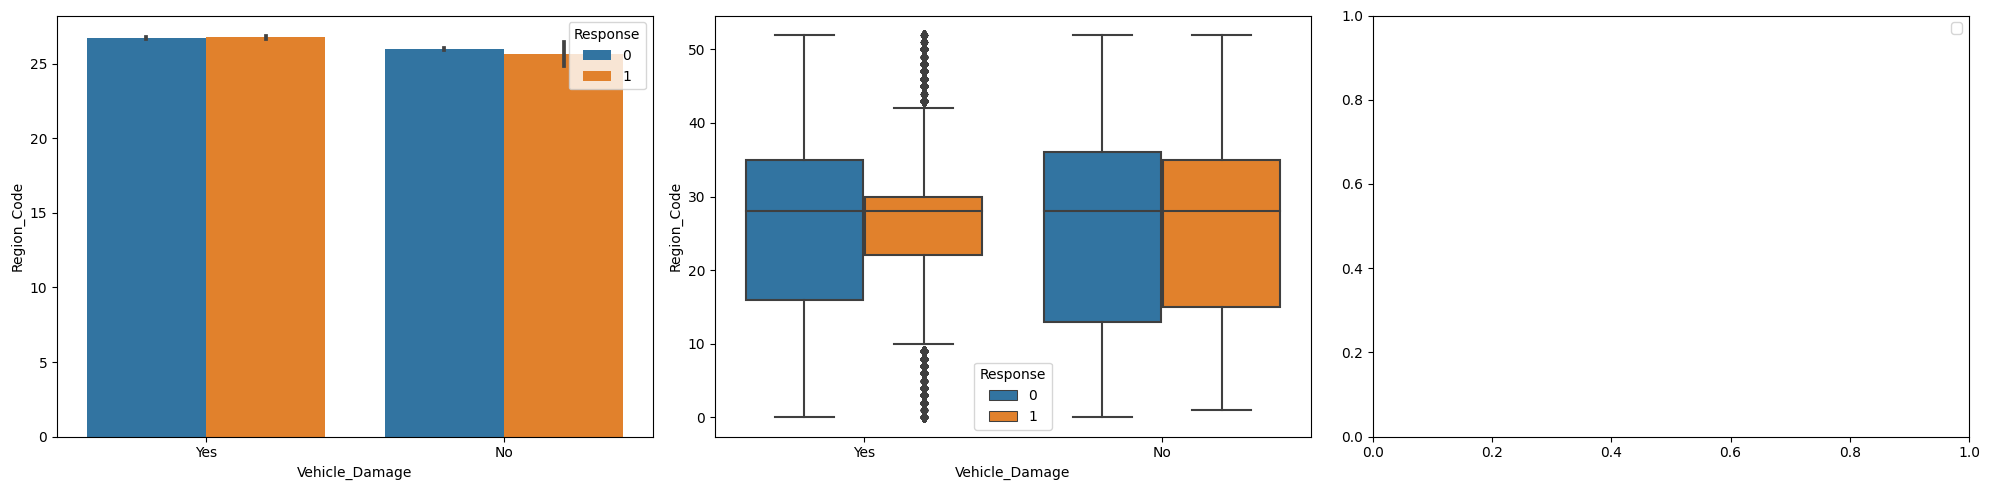

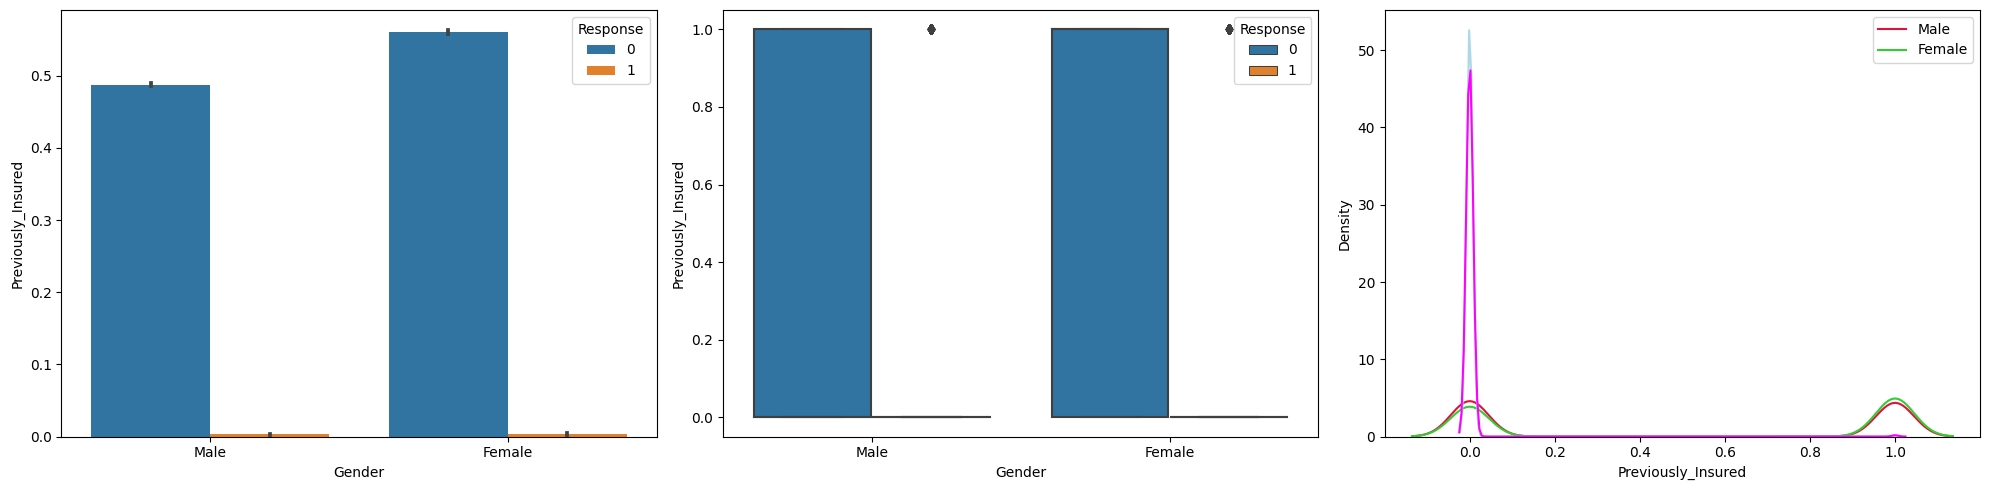

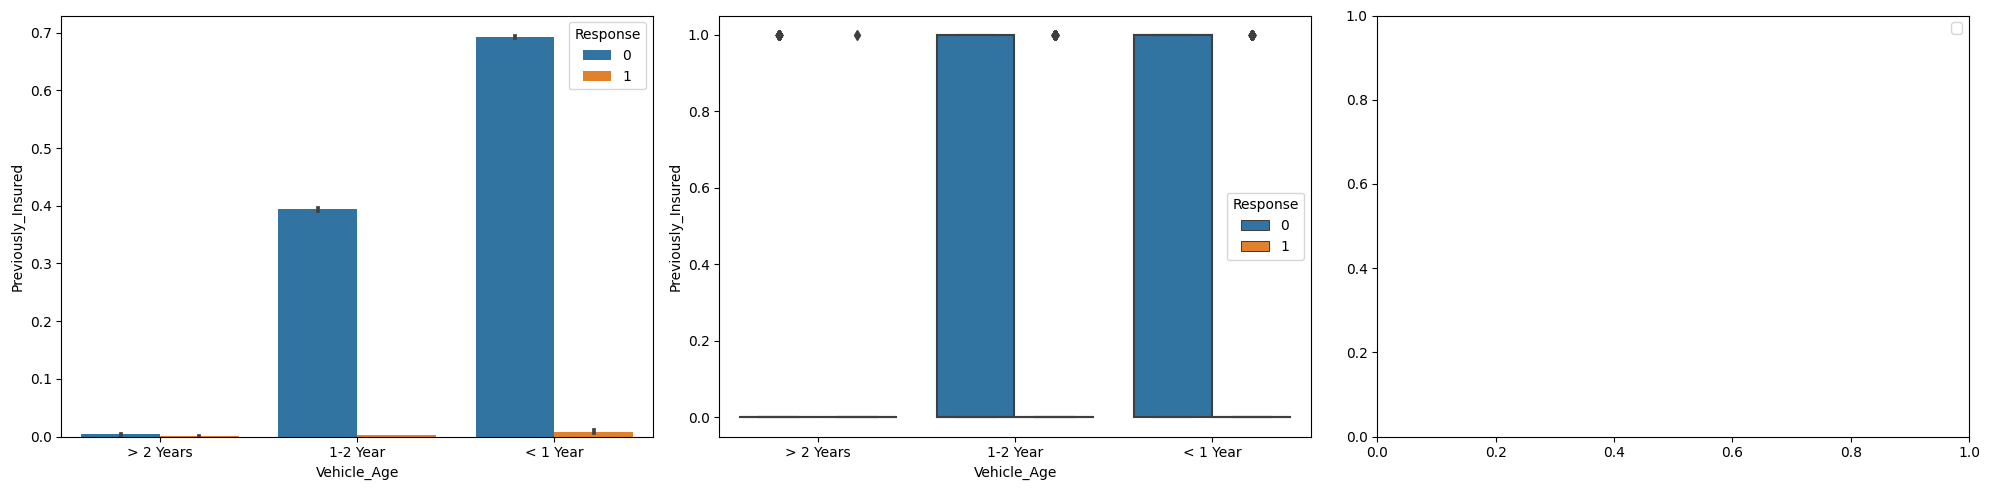

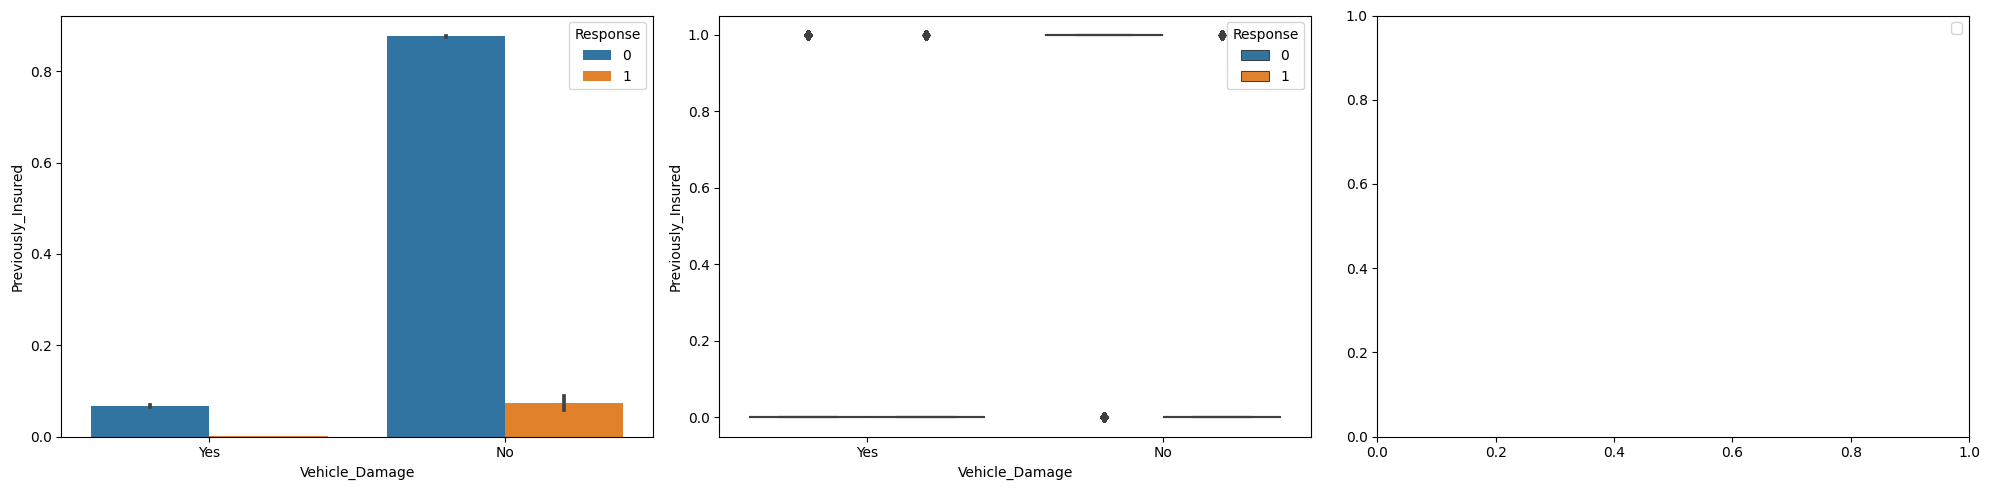

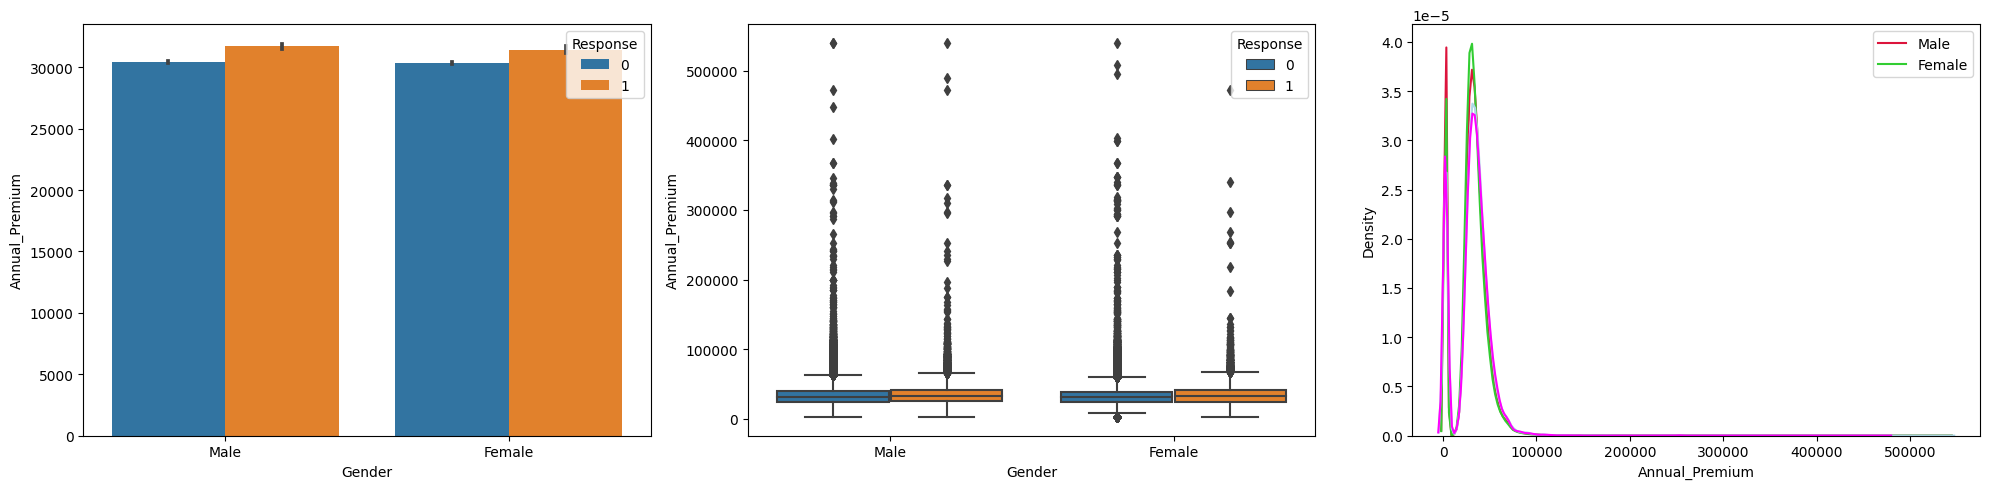

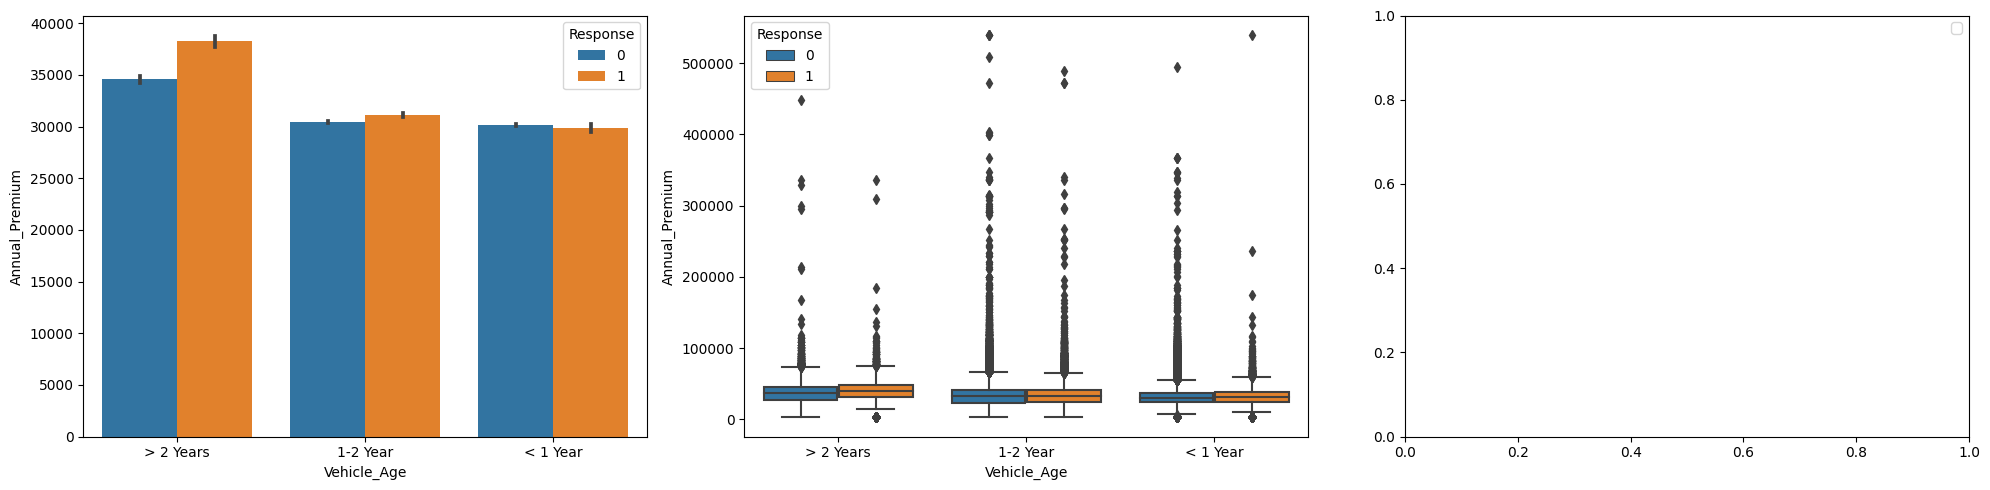

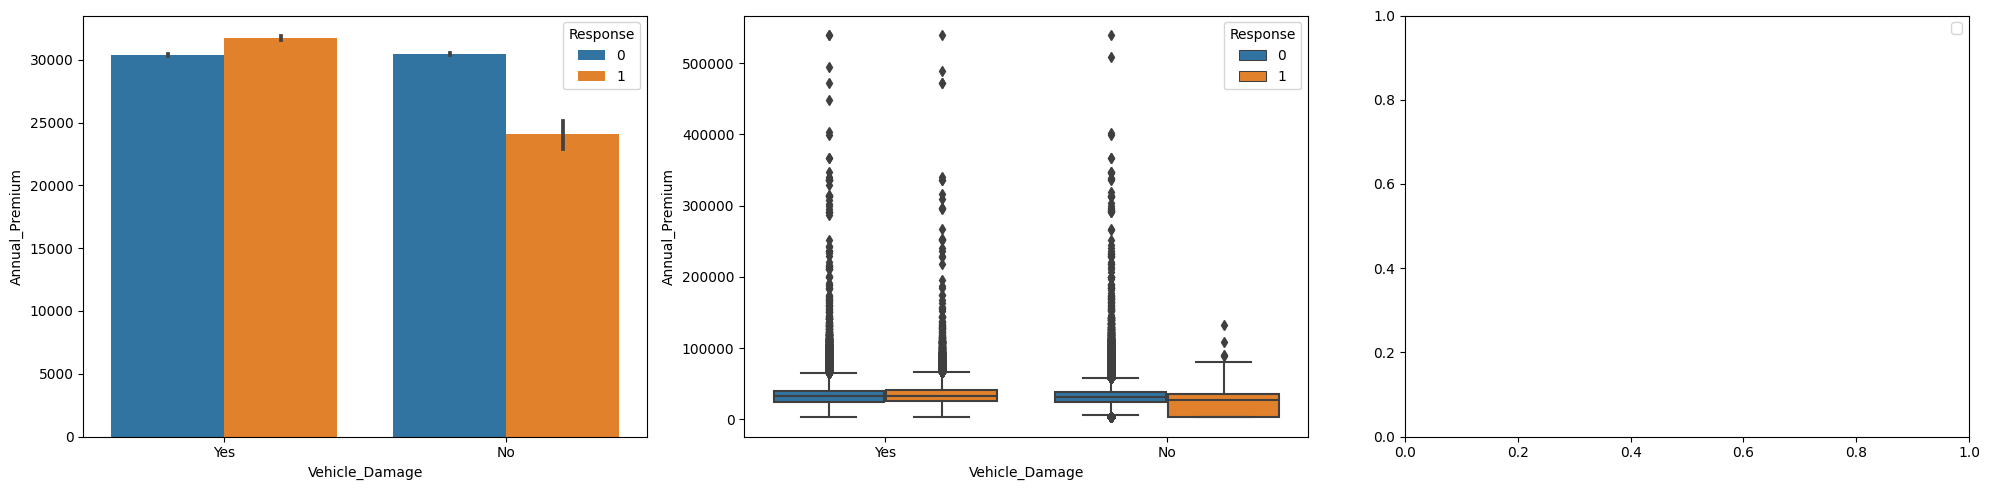

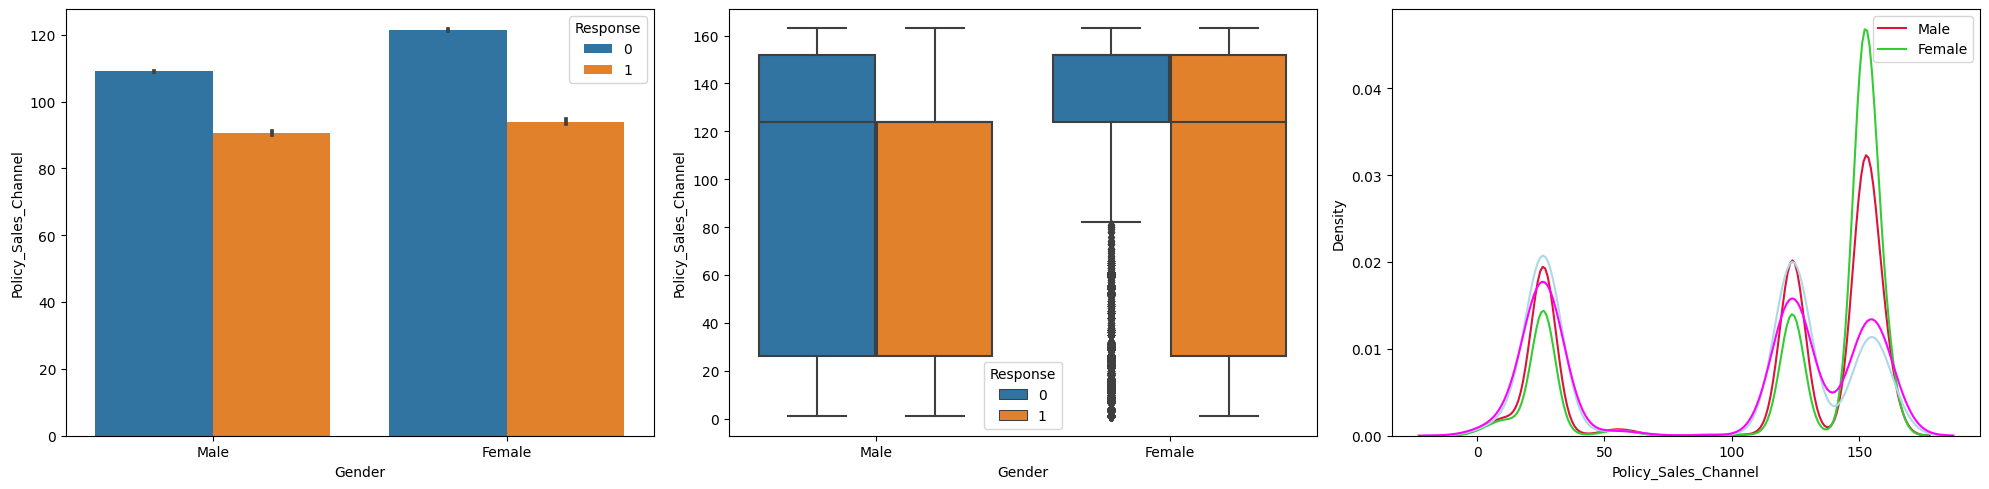

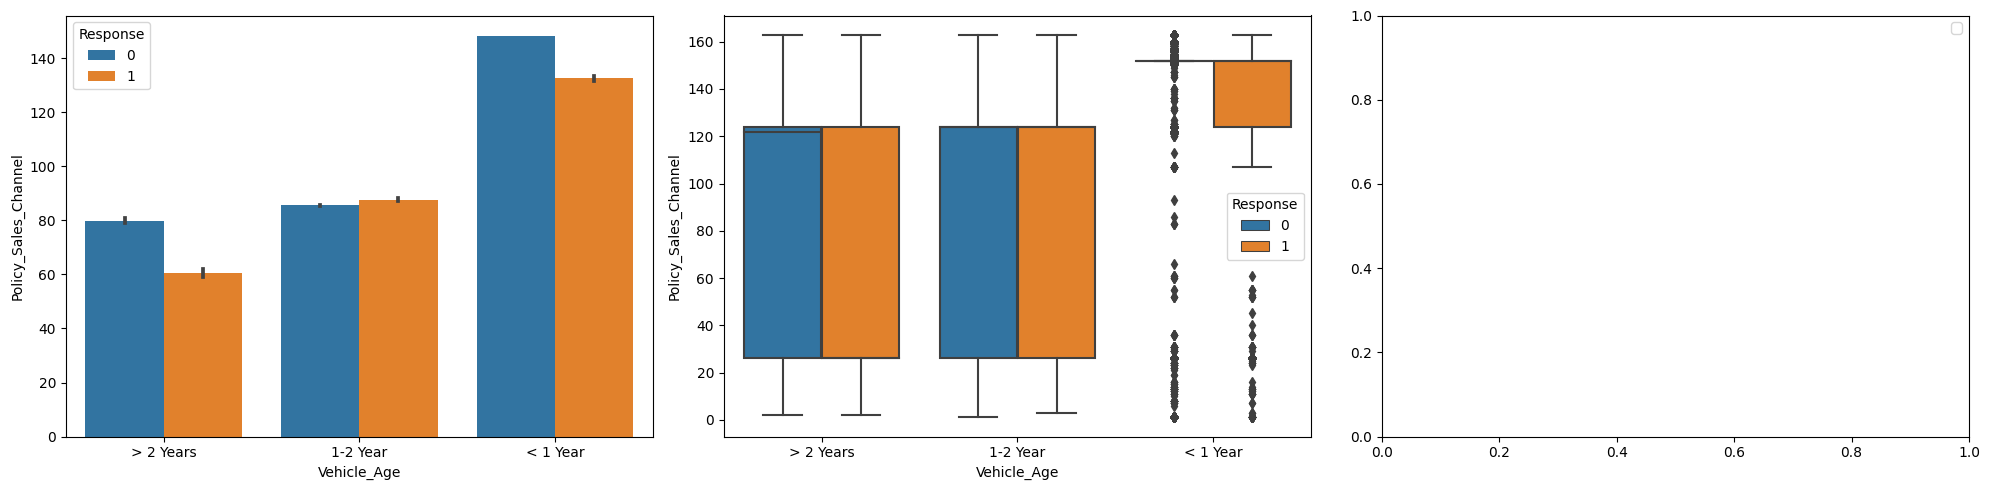

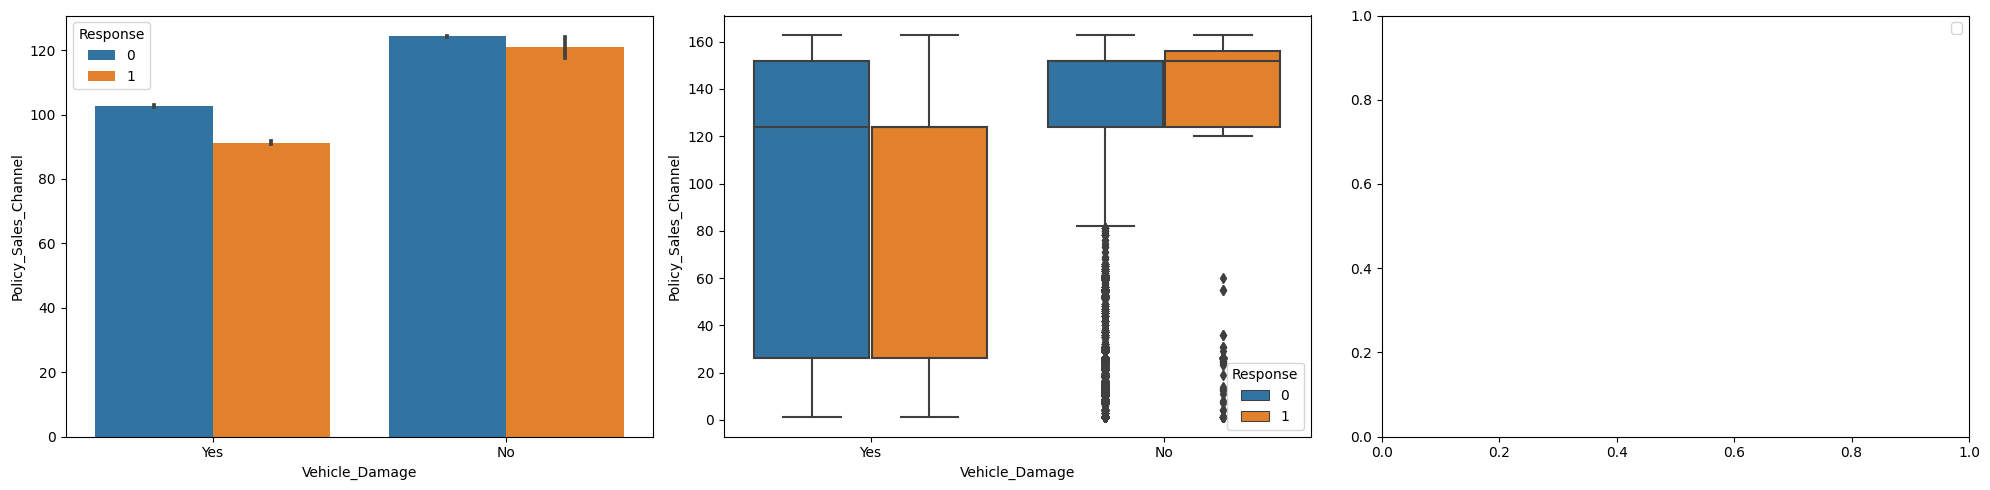

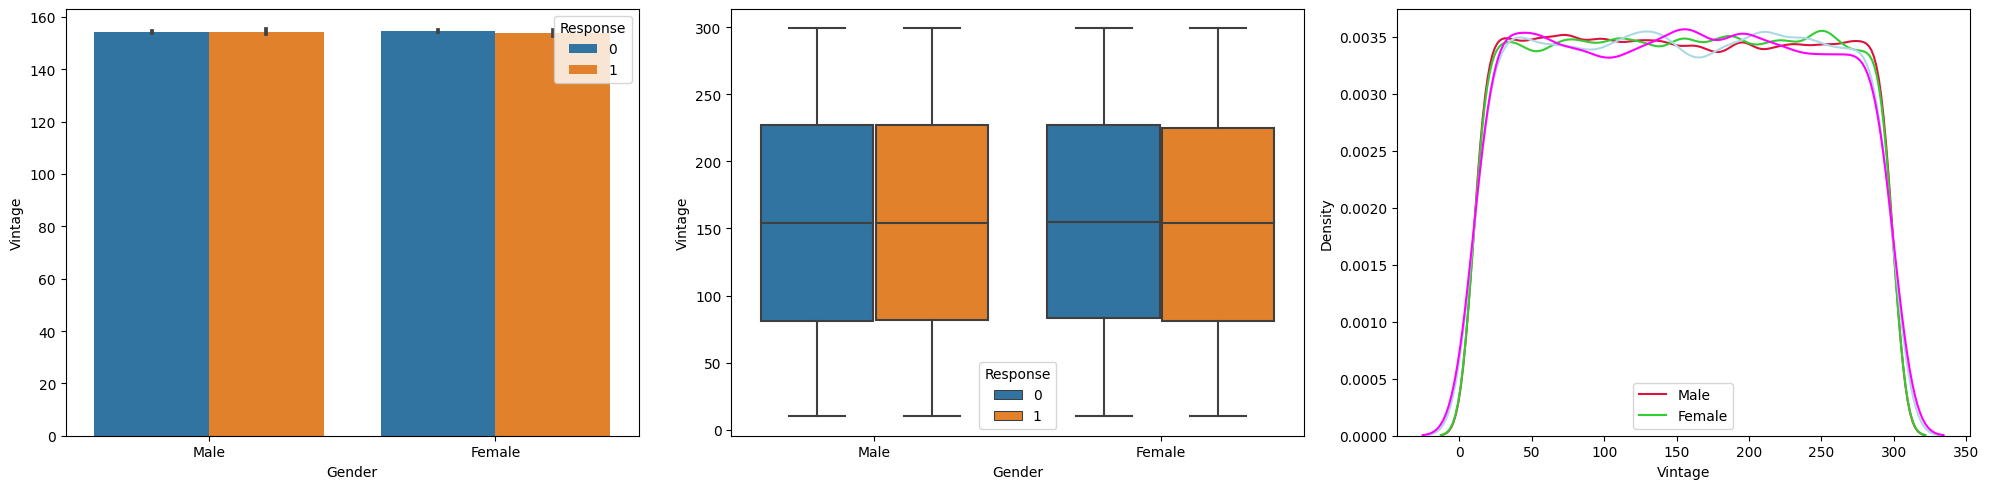

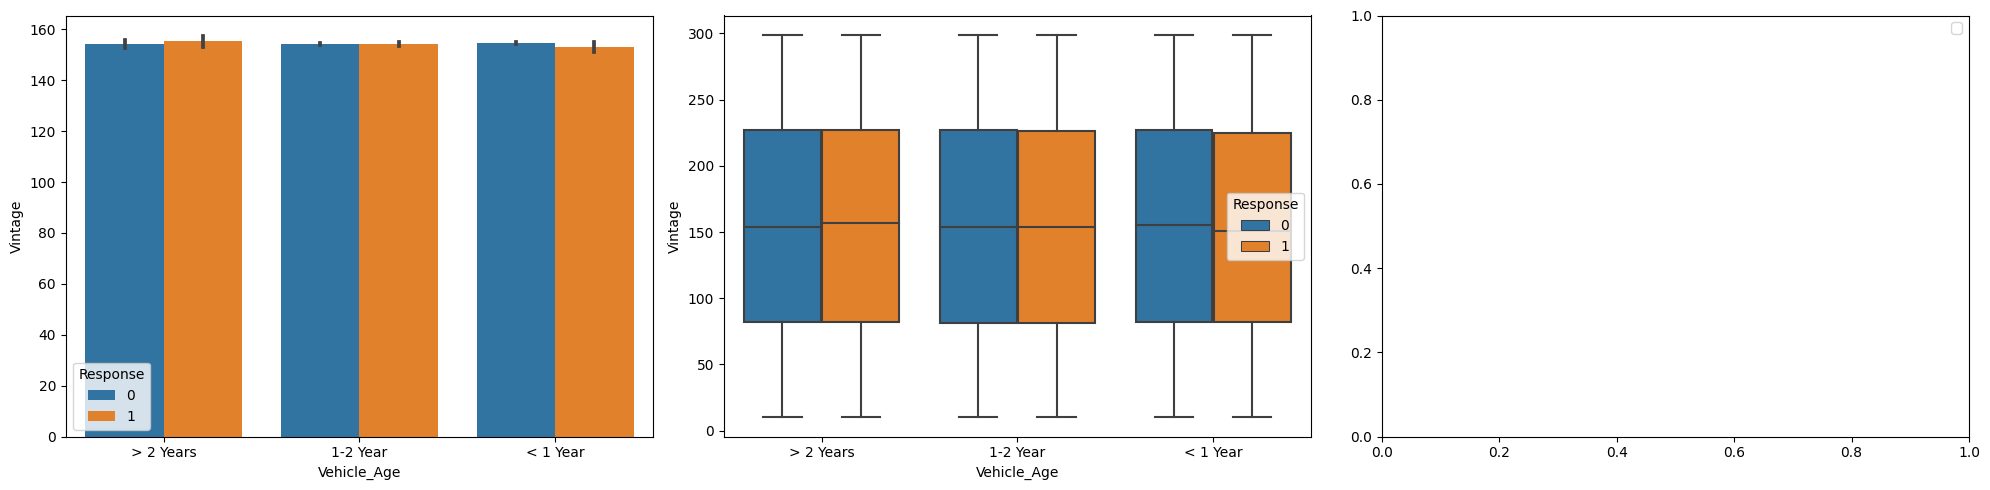

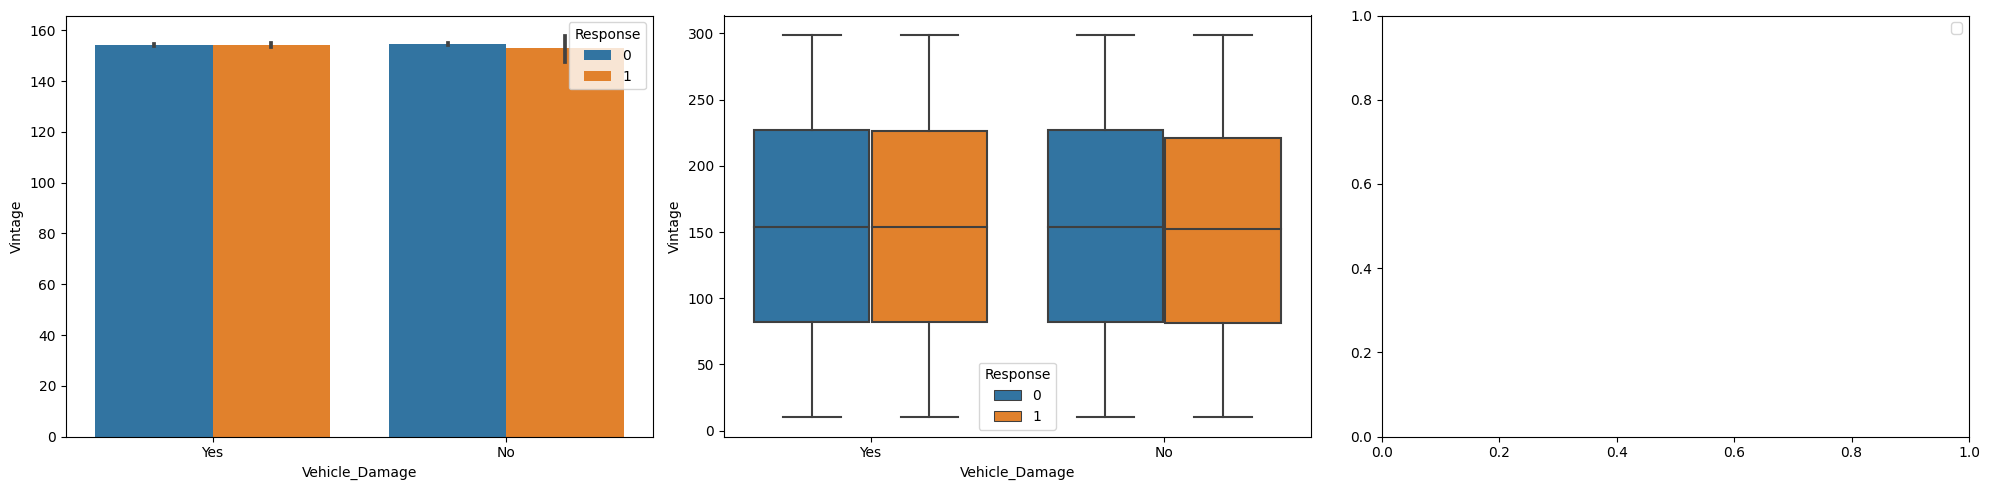

In [100]:
for num_feature in numeric_features:
  for cat_feature in categorical_features:
    fig, ax = plt.subplots(1,3,figsize=(20, 5))
    sns.barplot(data=df,x=df[cat_feature],y=df[num_feature],hue=df[target],ax=ax[0])
    sns.boxplot(data=df,x=df[cat_feature],y=df[num_feature],hue=df[target],ax=ax[1])
    sns.kdeplot(df[(df['Response'] == 0) & (df[cat_feature] == 'Male' ) ][num_feature],color='crimson',fill=False,label='No')
    sns.kdeplot(df[(df['Response'] == 0) & (df[cat_feature] == 'Female' ) ][num_feature],color='limegreen',fill=False,label='No')
    sns.kdeplot(df[(df['Response'] == 1) & (df[cat_feature] == 'Male') ][num_feature],color='lightblue',fill=False,label='Yes')
    sns.kdeplot(df[(df['Response'] == 1) & (df[cat_feature] == 'Female') ][num_feature],color='Magenta',fill=False,label='Yes')
    plt.legend(labels=["No","Yes"])
    plt.legend(labels=["Male","Female"])
    plt.tight_layout()
    fig.show()

#### Observation of bivarient Analysis 
  1. Observation of outliers in term of `Annual Premium` with `Target` (fig 1.2)
- The people who took `100000 - 150000` Annual Premium tend to show less interested in Vehicle Insurance. 
- The people who took `150000 - 300000` Annual Premium tend to interested in Vehicle Insurance. 
- Same increase in interest we can see in between `400000 - 600000`.
- We can't drop this outliers we have to take this values as consideration  
  2. Observation of outliers in term of `Annual Premium` with `Vintage (No of days customer associated with campany)` (fig 1.3)
- The people who we with company in between `150 - 250` days tend to interested in Vehicle Insurance. 

In [132]:
dtd  = DecisionTreeDiscretiser(cv=10,scoring='accuracy',variables=['Annual_Premium'],regression=False,param_grid={
    'max_depth':[3,4,5,6,7,8],    
})

In [133]:
train_size = int(np.ceil(90/100*df.shape[0]))
test_size = df.shape[0] - train_size

In [134]:
dtd  = dtd.fit(df.iloc[:train_size,:-1],df.iloc[:train_size,-1])

In [136]:
dtd.binner_dict_['Annual_Premium'].best_params_

{'max_depth': 3}

In [137]:
test_df =  df.copy()

In [143]:
test_df = dtd.transform(test_df.iloc[:,:-1])

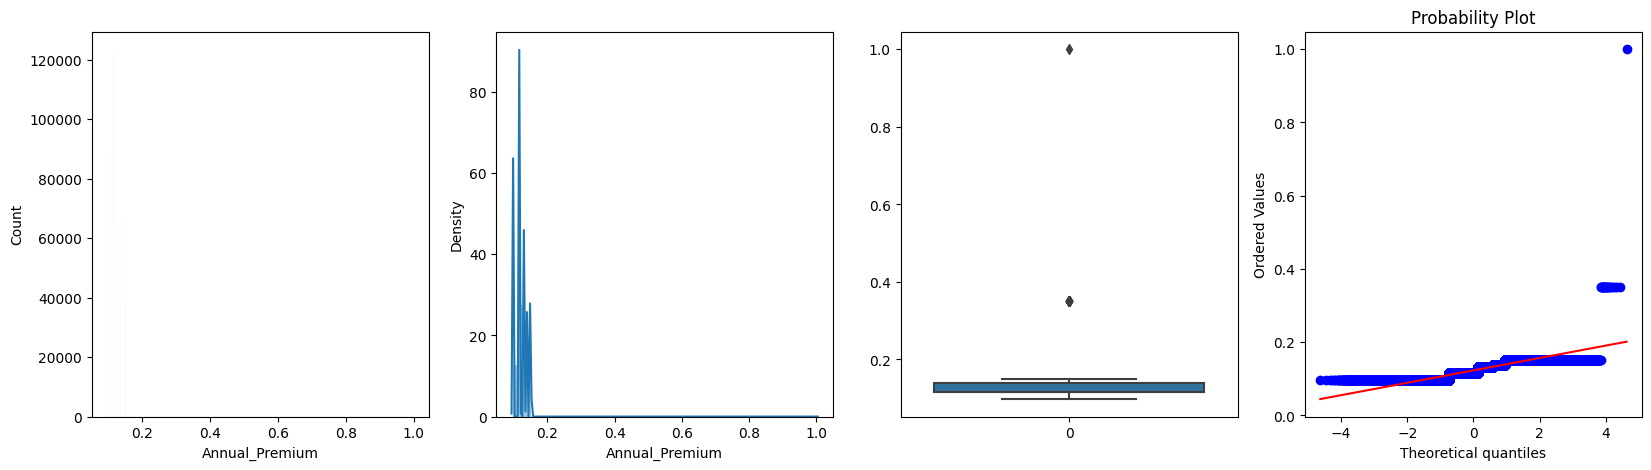

In [144]:

fig, ax = plt.subplots(1,4,figsize=(20, 5))
sns.histplot(test_df['Annual_Premium'], ax=ax[0])
sns.distplot(test_df['Annual_Premium'], ax=ax[1])
sns.boxplot(test_df['Annual_Premium'],ax=ax[2])
stats.probplot(test_df['Annual_Premium'], plot=ax[3], fit=True)
fig.show()

In [145]:
Q3 = np.percentile(test_df['Annual_Premium'], 75, axis=0)
Q1 = np.percentile(test_df['Annual_Premium'], 25, axis=0)
IQR = Q3-Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR
print(Q1,Q3,IQR,upper_bound,lower_bound)

0.117029906933924 0.13882751298459067 0.021797606050666676 0.1715239220605907 0.08433349785792399
